## Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import shap
import catboost
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pygam import LinearGAM
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from statsmodels.stats.diagnostic import het_breuschpagan
from typing import List, Dict, Tuple
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
import matplotlib.dates as mdates
from matplotlib.dates import WeekdayLocator
import holidays
sys.path.append('/Users/i.nuriev/repository/mmm-tools/mmm_tools')
from model_plotting import *
from media_transformation import media_impact_runet  # media_impact
import warnings
warnings.filterwarnings('ignore')

In [3]:
def SMAPE(y_true, y_pred):
    """
    Рассчитывает Symmetric Mean Absolute Percentage Error (SMAPE).
    
    Параметры:
    y_true : array-like
        Фактические значения.
    y_pred : array-like
        Предсказанные значения.
        
    Возвращает:
    float
        Значение SMAPE.
    """
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

def RMSE(y_pred, y_true):
    n = len(y_pred)
    return  np.sqrt(1 / n * sum((y_true - y_pred) ** 2))

def WAPE(y_pred, y_true):
    return sum(abs((y_true - y_pred))) / sum(y_true) * 100 

In [4]:
df = pd.read_csv('df_final_dau.csv')
df = df[df.dt >= '2022-09-19'] # Ограничим период # 2022-08-01

In [5]:
df.index = df.dt

In [6]:
df.drop(columns='dt',inplace=True)

In [7]:
kpi = 'dau_ok_35_plus_relative'
non_media_final_factors = ['dau_dzen_35_plus',
                           'dummy_holidays',
                           'dau_youtube_35_plus',
                           # 'dummy_show_bur',
                           'product_performance_ots',
                           'product_activity_piar_ots',
                           'dau_instagram_35_plus',
                           'seasonality_weekly_dau',
                           'trend_linear_dau',
                           'trend_prophet_dau',
                           'seasonality_yearly_dau',
                           'wordstat_num_of_queries', 
                           'wordstat_perc_of_total_queries',
                           'aa_prompted_kpi_percent_ttl_roll',
                           'ba_spontaneous_kpi_percent_ttl_roll',
                           'consid_kpi_percent_ttl_roll']
media_factors = ['digital_media_ots', 'performance_ots','bloggers_ots', 'tv_ots','ooh_ots','metro_ots','radio_ots']

model_factors = non_media_final_factors+media_factors

In [8]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [9]:
# Таблица с общими результатами
res = pd.DataFrame(index=['WAPE','SMAPE','RMSE'])

**Разделим выборку на train/test**

In [10]:
X = df[model_factors]
y = df[kpi]

horizon = 10
X_train = X.head(-horizon)
y_train = y.head(-horizon)

X_test = X.tail(horizon)
y_test = y.tail(horizon)

## Тест на мультиколлинеарность (VIF)

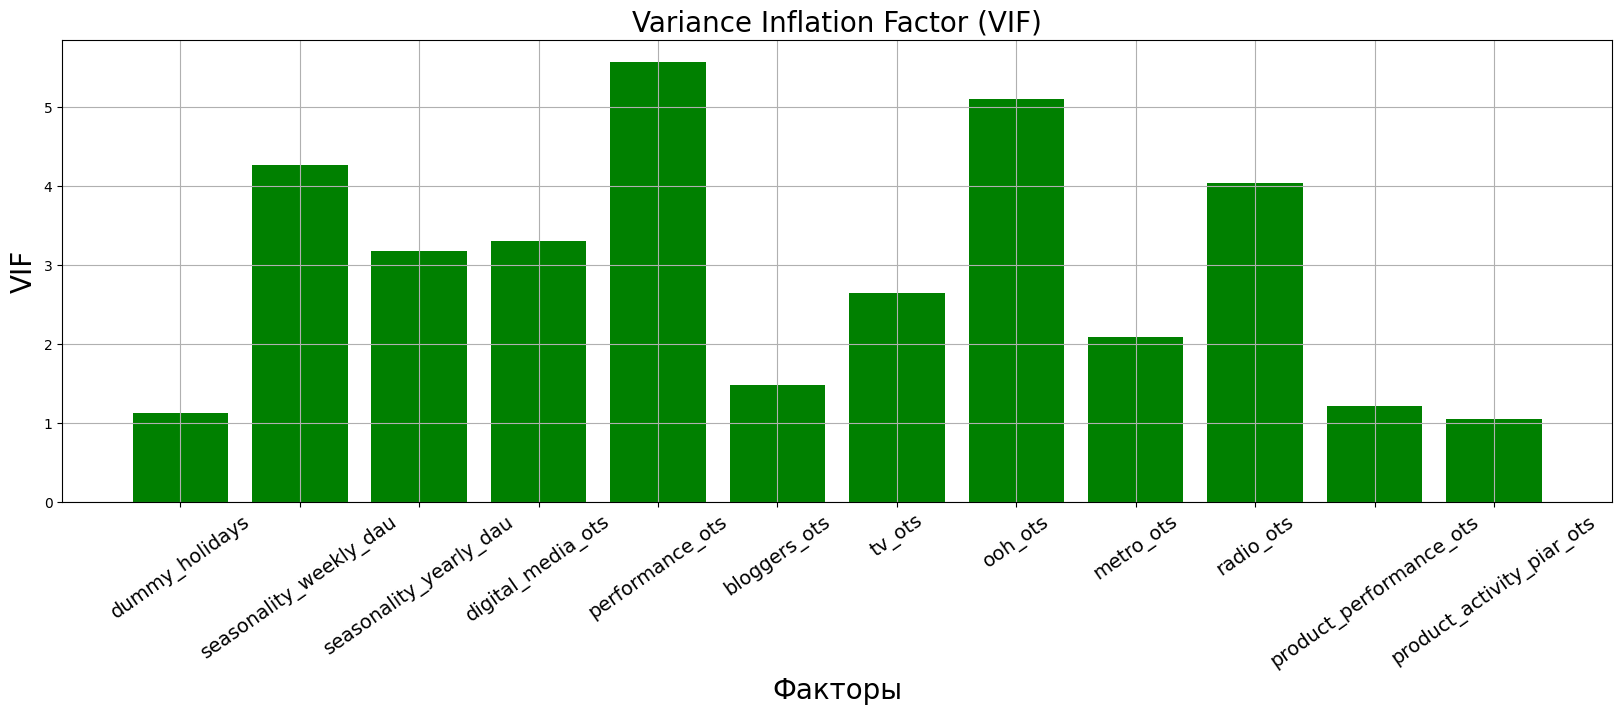

In [11]:
# Вычисляем VIF для каждого признака

non_media_final_factors_ = [
                 'dummy_holidays',
                'seasonality_weekly_dau','seasonality_yearly_dau']
model_factors_ = non_media_final_factors_+media_factors + ['product_performance_ots','product_activity_piar_ots']
vif_data = pd.DataFrame()
d = X_train[model_factors_]
vif_data["feature"] = d.columns
vif_data["VIF"] = [variance_inflation_factor(d.values, i) for i in range(d.shape[1])]

# Строим график bar для VIF значений
plt.figure(figsize=(20, 6))
plt.bar(vif_data["feature"], vif_data["VIF"], color='green')
plt.xlabel('Факторы',fontsize=20)
plt.ylabel('VIF',fontsize=20)
plt.grid(True)
plt.title('Variance Inflation Factor (VIF)',fontsize=20)
plt.xticks(vif_data["feature"], vif_data["feature"].values, rotation=35,fontsize=14)
plt.show()

Данный набор факторов не приводит к проблеме мультиколлинеарности

## **Моделирование DAU**

**Используем HAC (Heteroskedasticity and Autocorrelation Consistent) матрицу ковариаций коэффициентов регрессии для более точного определения стат.значимости**

In [12]:
non_media_final_factors = ['dau_dzen_35_plus',
                           'dummy_holidays',
                           'dau_youtube_35_plus',
                           'product_performance_ots',
                           'product_activity_piar_ots',
                           # 'dummy_show_bur',
                           #'dau_instagram_35_plus',
                           #'seasonality_weekly_dau',
                           # 'trend_linear_dau',
                           'seasonality_yearly_dau',
                           'wordstat_num_of_queries', 
                           # 'wordstat_perc_of_total_queries',
                           # 'aa_prompted_kpi_percent_ttl_roll',
                           'ba_spontaneous_kpi_percent_ttl_roll']

model_factors = non_media_final_factors+media_factors

In [13]:
lag_value = 1 # количество лагов для вычисления HAC оценки
model = sm.OLS(y_train,sm.add_constant(X_train[model_factors]))
result = model.fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     dau_ok_35_plus_relative   R-squared:                       0.721
Model:                                 OLS   Adj. R-squared:                  0.713
Method:                      Least Squares   F-statistic:                     73.57
Date:                     Mon, 10 Jun 2024   Prob (F-statistic):          7.73e-123
Time:                             14:51:37   Log-Likelihood:                 2089.6
No. Observations:                      590   AIC:                            -4147.
Df Residuals:                          574   BIC:                            -4077.
Df Model:                               15                                         
Covariance Type:                       HAC                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

### **Аддитивный эффект от total**

In [14]:
non_media_final_factors = ['dau_dzen_35_plus',
                           'dummy_holidays',
                           'dau_youtube_35_plus',
                           'product_performance_ots',
                           'product_activity_piar_ots',
                           # 'dummy_show_bur',
                           #'dau_instagram_35_plus',
                           #'weekly_seasonality_dau',
                           # 'trend_linear_dau',
                           'seasonality_yearly_dau',
                           'wordstat_num_of_queries', 
                           # 'wordstat_perc_of_total_queries',
                           # 'aa_prompted_kpi_percent_ttl_roll',
                           'ba_spontaneous_kpi_percent_ttl_roll']

In [15]:
df['media_online_ots'] = df['bloggers_ots'] + df['digital_media_ots'] + df['performance_ots']
df['media_offline_ots'] =  df['metro_ots'] + df['radio_ots'] + df['tv_ots'] + df['ooh_ots']
df['media_total_ots'] = df['media_online_ots'] + df['media_offline_ots']

### **Построим вложенные регрессии BHT-метрик от медиа-факторов**

Известно, что медиа-активности влияют на BHT-метрики (в частности на BA) и на продуктовые метрики (в данном случае на DAU/TimeSpent). При этом, мы полагаем, что BA влияет на DAU - чем выше доля тех, кто знает бренд, тем больше активных пользователей у проекта (при прочих равных). В данном случае, может возникать проблема эндогенности - ситуация, когда факторы в линейной регрессии коррелируют с ошибкой модели, или проблема пропущенной переменной.  Поэтому для того, чтобы наиболее точно оценить влияние медиа-активности на DAU, нужно реализовать подход с вложенными регрессиями - в частности, двухшаговый МНК:

***Классический подход с 2-МНК:***
1) $\widehat{BA_t} = b_0 + b_1\cdot totalmedia_t$
2) $DAU_t = \gamma_0 + \gamma_1\cdot \widehat{BA_t}  + \varepsilon_t$

То есть в итоговую модель $DAU_t$ включаем $\widehat{BA_t}$ без медиа-активностей. Поэтому для определения вклада медиа в продуктовую метрику (в нашем случае - в DAU), нужно подставить уравнение 1) в 2) и выделить этот эффект:

$DAU_t = \gamma_0 + \gamma_1\cdot \widehat{BA_t}  + \varepsilon_t =\gamma_0 + \gamma_1\cdot(b_0 + b_1\cdot totalmedia_t) + \varepsilon_t$

$\Rightarrow$ $DAU_t = \widetilde{\gamma_0} + \widetilde{\gamma_1}\cdot totalmedia_t + \varepsilon_t$, где 

$\widetilde{\gamma_0} = (\gamma_0 + \gamma_1\cdot b_0)$ - константа

$\widetilde{\gamma_1} = \gamma_1\cdot b_1$ - коэффициент, отражающий влияние медиа-активностей на $DAU_t$

***2-МНК с очищением BA от медиа-факторов***
1) $BA_t = b_0 + b_1\cdot totalmedia_t + \varepsilon_t = \widehat{BA_t} + \varepsilon_t$

$\Rightarrow$ ${BA_t}^{adjusted} = BA_t - b_1\cdot totalmedia_t$

2) $DAU_t = \gamma_0 + \gamma_1\cdot totalmedia_t + \gamma_2\cdot {BA_t}^{adjusted}$

In [16]:
df_bht = pd.read_excel('../actual_data.xlsx',sheet_name='bht',header=4)
# ставим дату в индекс
df_bht.index = df_bht.date_start

**Выделим тренд и сезонность в BA**

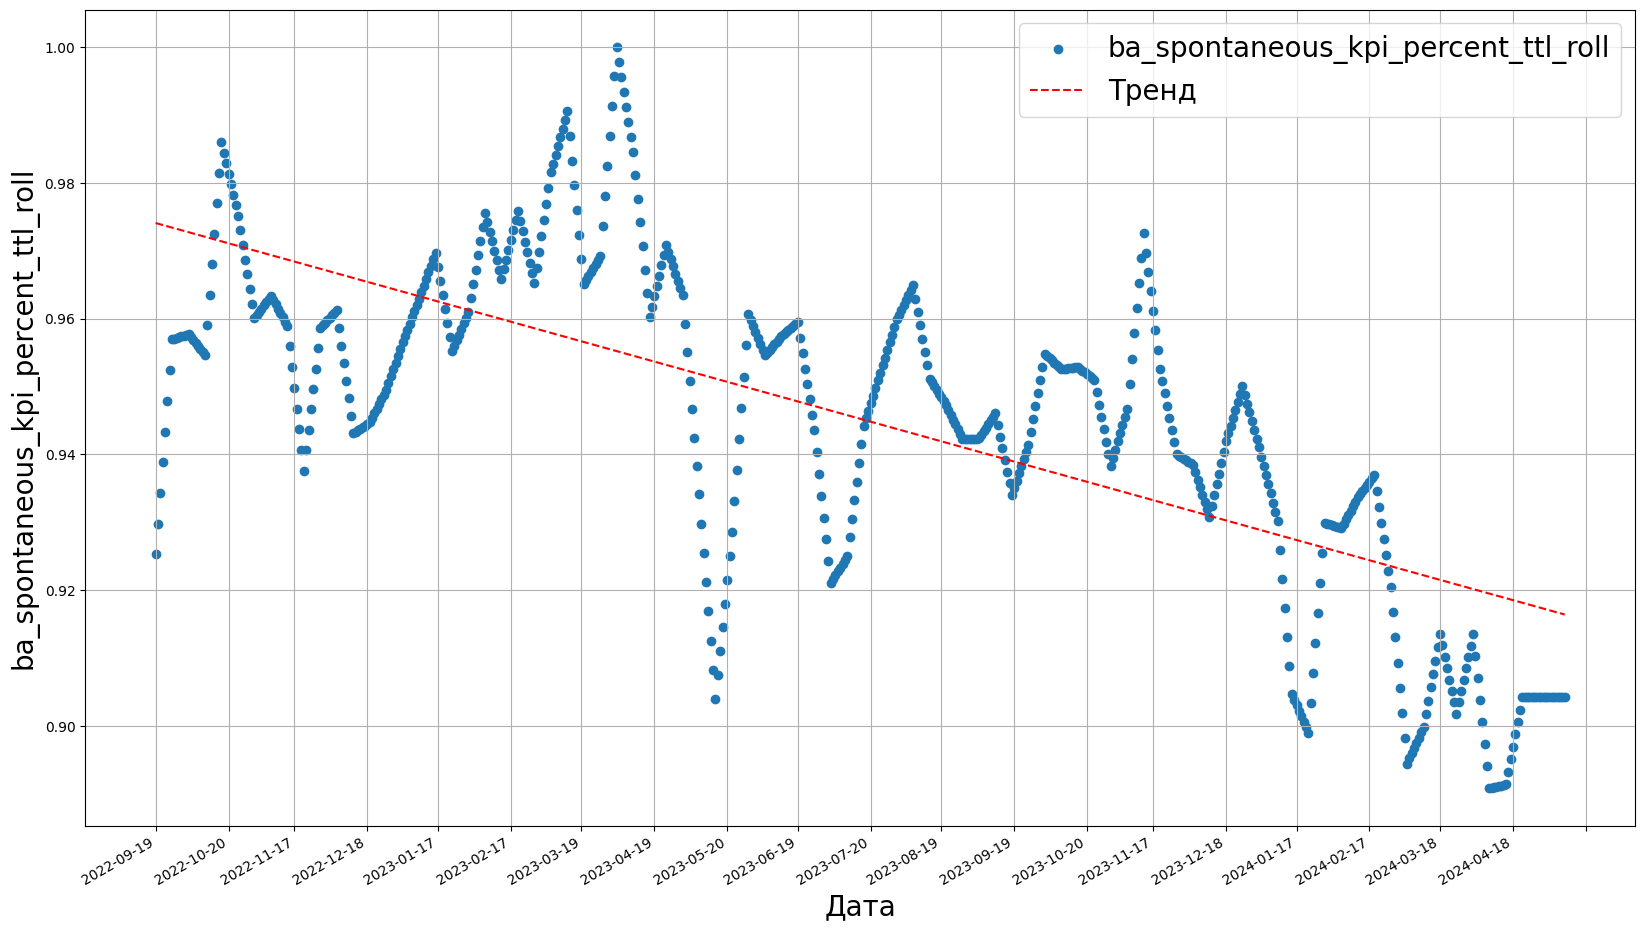

In [17]:
plt.figure(figsize = (20,12))
# kpi
plt.scatter(df.index, df.ba_spontaneous_kpi_percent_ttl_roll, label='ba_spontaneous_kpi_percent_ttl_roll')
# вычисляем тренд
horizont = range(len(df.index))
coefs = np.polyfit(horizont, df.ba_spontaneous_kpi_percent_ttl_roll, 1) # кф-ты тренда
trend = np.poly1d(coefs) 
plt.plot(np.array(df.index), trend(horizont), "r--", label='Тренд')
plt.xlabel('Дата',fontsize=20)
plt.ylabel('ba_spontaneous_kpi_percent_ttl_roll',fontsize=20)
plt.grid(True)
plt.legend(fontsize=20)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
# Отображаем график
plt.show()

In [18]:
df['trend_linear_ba']=trend(horizont)

In [19]:
ba = df.ba_spontaneous_kpi_percent_ttl_roll
aa = df.aa_prompted_kpi_percent_ttl_roll
consid = df.consid_kpi_percent_ttl_roll
ba_factors = df['media_total_ots']# [media_factors + ['show_bur']]
bht = df[['ba_spontaneous_kpi_percent_ttl_roll','aa_prompted_kpi_percent_ttl_roll', 'consid_kpi_percent_ttl_roll']]
model_2mnk = sm.OLS(ba,sm.add_constant(ba_factors,has_constant='add')).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})
results_2mnk= model_2mnk.summary()
print(results_2mnk)

ba_adj = ba - model_2mnk.params[1]*ba_factors # model_2mnk.fittedvalues

                                     OLS Regression Results                                    
Dep. Variable:     ba_spontaneous_kpi_percent_ttl_roll   R-squared:                       0.053
Model:                                             OLS   Adj. R-squared:                  0.052
Method:                                  Least Squares   F-statistic:                     18.26
Date:                                 Mon, 10 Jun 2024   Prob (F-statistic):           2.24e-05
Time:                                         14:51:37   Log-Likelihood:                 1421.6
No. Observations:                                  600   AIC:                            -2839.
Df Residuals:                                      598   BIC:                            -2830.
Df Model:                                            1                                         
Covariance Type:                                   HAC                                         
                      coef    std err   

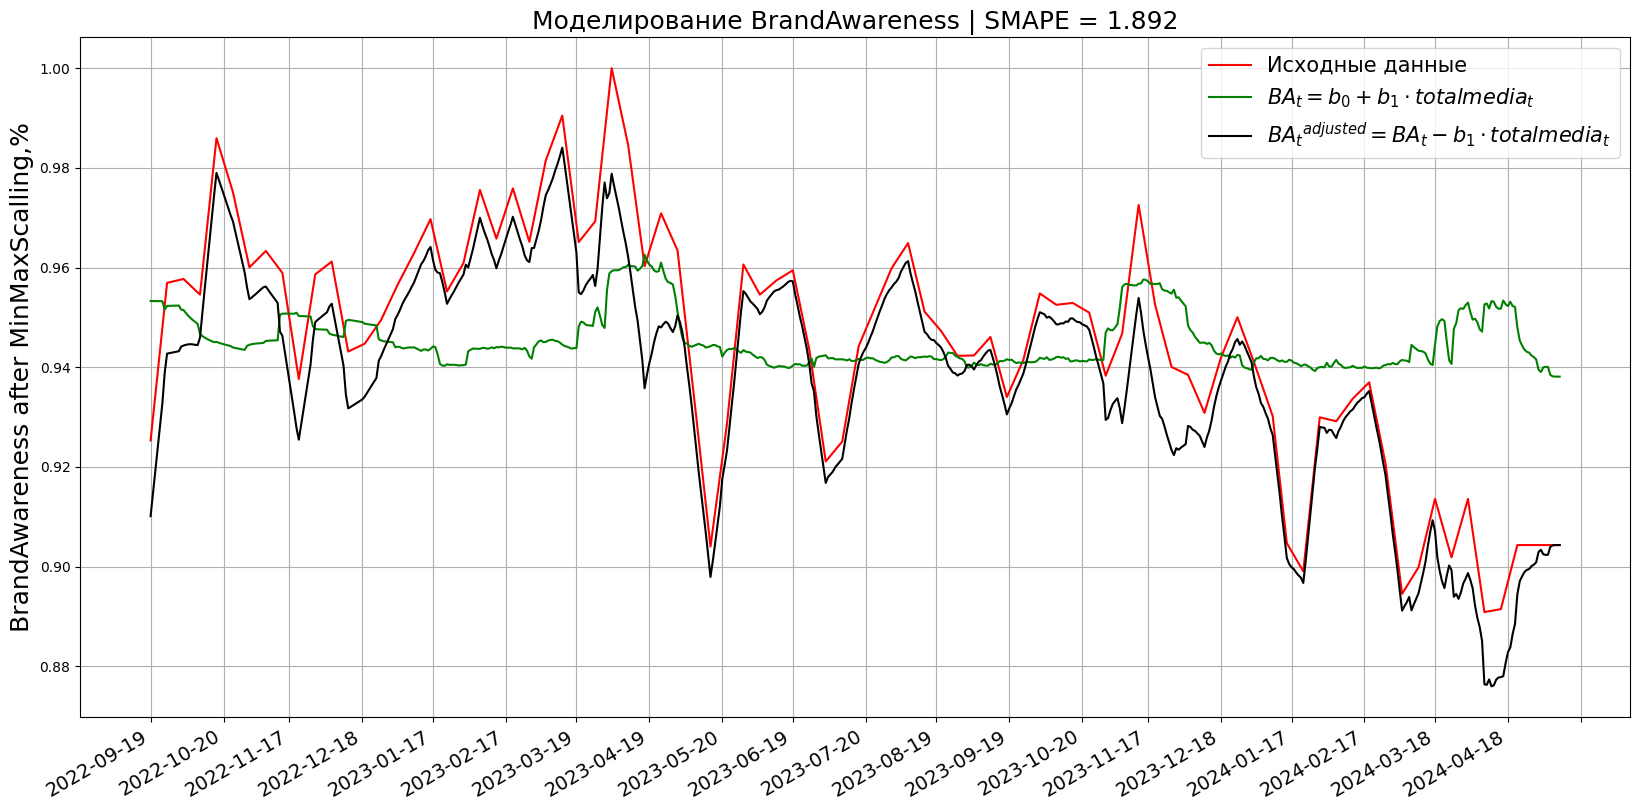

In [20]:
plt.figure(figsize=(20, 10))

# График исходных данных
plt.plot(ba.index, ba, label='Исходные данные', color='red')

# График предсказанных значений
plt.plot(model_2mnk.fittedvalues.index, model_2mnk.fittedvalues, color='green', label='$BA_t=b_0 + b_1\cdot totalmedia_t$')

plt.plot(ba_adj.index, ba_adj, color='black', label='${BA_t}^{adjusted} = BA_t - b_1\cdot totalmedia_t$')

plt.ylabel('BrandAwareness after MinMaxScalling,%', fontsize=18)
plt.xticks(fontsize=14)
plt.title(f'Моделирование BrandAwareness | SMAPE = {round(SMAPE(ba,model_2mnk.fittedvalues),3)}', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()

plt.show()

In [21]:
df['ba_spontan_perc_roll_fitted_values'] =  model_2mnk.fittedvalues
df['ba_spontan_perc_roll_adj_wo_media'] =  ba_adj

In [22]:
non_media_final_factors = ['dau_dzen_35_plus',
                           'dummy_holidays',
                           'dau_youtube_35_plus',
                           #'product_performance_ots',
                           #'product_activity_piar',
                           # 'dummy_show_bur',
                           #'dau_instagram_35_plus',
                           'seasonality_weekly_dau',
                           #'trend_prophet',
                           'seasonality_yearly_dau',
                           #'wordstat_num_of_queries',
                           #'aa_spontan_perc_roll_adj',
                           'ba_spontan_perc_roll_fitted_values']
                           #'consid_spontan_perc_roll_adj'
                           # 'wordstat_perc_of_total_queries',
                           #'aa_prompted_kpi_percent_ttl_roll'

model_factors = non_media_final_factors # + ['total_media']
X = df[model_factors].copy()

X_train = X.head(-horizon)
y_train = y.head(-horizon)

X_test = X.tail(horizon)
y_test = y.tail(horizon)

X_train = X_train.reindex(y_train.index)

In [23]:
np.set_printoptions(suppress=True) # отключаем научную нотацию
model = sm.OLS(y_train,X_train).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})

results_summary = model.summary()
print(results_summary)

# Рассчитываем прогноз
forecast = model.get_prediction(X_test)

# Точечный рогноз
forecast_values = forecast.predicted_mean
# Интервальный прогноз (доверительный интервал)
forecast_intervals = forecast.conf_int()
print(f'Линейная регрессия от total_media\nМетрики на тестовой выборке:\nSMAPE:{round(SMAPE(forecast_values,y_test),3)}\nWAPE:{round(WAPE(forecast_values,y_test),3)}\nRMSE:{round(RMSE(forecast_values,y_test),3)}')
res['additive_2mnk_linear_reg_1'] = round(WAPE(forecast_values,y_test),3), round(SMAPE(forecast_values,y_test),3),round(RMSE(forecast_values,y_test),3)

                                   OLS Regression Results                                   
Dep. Variable:     dau_ok_35_plus_relative   R-squared (uncentered):                   0.999
Model:                                 OLS   Adj. R-squared (uncentered):              0.999
Method:                      Least Squares   F-statistic:                          9.077e+04
Date:                     Mon, 10 Jun 2024   Prob (F-statistic):                        0.00
Time:                             14:51:38   Log-Likelihood:                          2045.0
No. Observations:                      590   AIC:                                     -4078.
Df Residuals:                          584   BIC:                                     -4052.
Df Model:                                6                                                  
Covariance Type:                       HAC                                                  
                                         coef    std err          z   

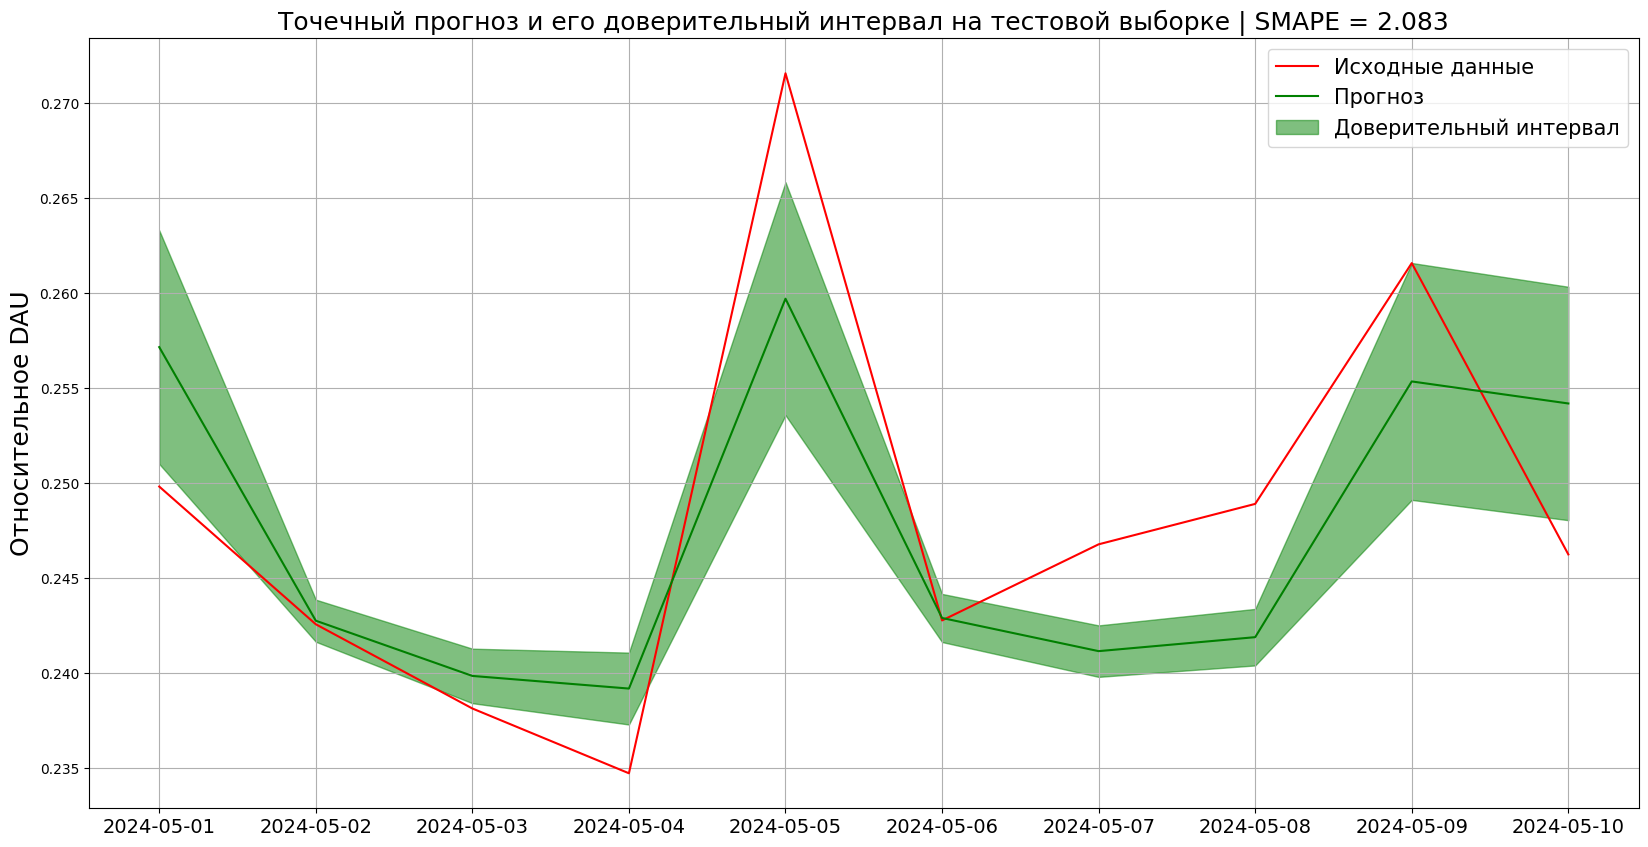

In [24]:
plt.figure(figsize=(20, 10))

# График исходных данных
plt.plot(y_test.index, y_test, label='Исходные данные', color='red')

# График предсказанных значений
plt.plot(y_test.index, forecast_values, color='green', label='Прогноз')

# # График доверительного интервала
plt.fill_between(y_test.index, forecast_intervals[:, 0], forecast_intervals[:, 1], color='green', alpha=0.5, label='Доверительный интервал')

plt.ylabel('Относительное DAU', fontsize=18)
plt.xticks(fontsize=14)
plt.title(f'Точечный прогноз и его доверительный интервал на тестовой выборке | SMAPE = {round(SMAPE(forecast_values,y_test),3)}', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)

# plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=mdates.MONDAY))
# plt.gcf().autofmt_xdate()

plt.show()

In [25]:
plot_decomposition(pd.concat([sm.add_constant(X_train[model_factors]),y_train],axis=1),model,kpi_name=kpi)

**Преобразование данных**

In [26]:
media_costs=pd.read_excel('../actual_data.xlsx',sheet_name='budget').fillna(0)
media_costs.index = media_costs.dt
media_costs=media_costs[media_costs.dt.ge('2024-03-18')&media_costs.dt.le('2024-04-30')].iloc[:,1:]

In [27]:
media_budget = pd.DataFrame({'budget':media_costs.sum(),
                             'date_start':'2024-03-18',
                             'date_end':'2024-04-30'},index = media_costs.sum().index )
media_budget.index = ['digital_media_ots', 'performance_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots']
other_factors = list(X_train.columns.values)

In [28]:
upd_params = pd.Series({'digital_media_ots':model_2mnk.params.get('media_total_ots')*model.params.get('ba_spontan_perc_roll_fitted_values'),
                        'performance_ots':model_2mnk.params.get('media_total_ots')*model.params.get('ba_spontan_perc_roll_fitted_values'),
                      'bloggers_ots':model_2mnk.params.get('media_total_ots')*model.params.get('ba_spontan_perc_roll_fitted_values'),
                      'tv_ots':model_2mnk.params.get('media_total_ots')*model.params.get('ba_spontan_perc_roll_fitted_values'), 
                      'ooh_ots':model_2mnk.params.get('media_total_ots')*model.params.get('ba_spontan_perc_roll_fitted_values'), 
                      'radio_ots':model_2mnk.params.get('media_total_ots')*model.params.get('ba_spontan_perc_roll_fitted_values'), 
                      'dau_dzen_35_plus':model.params.get('dau_dzen_35_plus'),
                      'dummy_holidays':model.params.get('dummy_holidays'),
                      'dau_youtube_35_plus':model.params.get('dau_youtube_35_plus'),
                      'seasonality_weekly_dau':model.params.get('seasonality_weekly_dau'),
                      'seasonality_yearly_dau':model.params.get('seasonality_yearly_dau'),
                      'wordstat_num_of_queries':model.params.get('wordstat_num_of_queries'),
                      'ba_spontan_perc_roll_fitted_values':model.params.get('ba_spontan_perc_roll_fitted_values')})

**Вклад РК в целевую метрику**

In [29]:
df['const']=1
date_start = '2024-03-18'
date_end = '2024-04-30'

In [30]:
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

res_media = media_impact_runet(df=df,
             df_flow_init=media_budget,
             media_factors=['digital_media_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots'],
             other_factors=other_factors + ['performance_ots'],
             kpi=kpi,
             runet_col = 'dau_runet_35_plus',
             model_params=upd_params)
res_media.date_start=date_start
res_media.date_end=date_end
res_media

Сценарий без РК: 15441901.8141


budget  date_start    date_end  \
digital_media_ots                   59533815.850  2024-03-18  2024-04-30   
performance_ots                      4122199.680  2024-03-18  2024-04-30   
bloggers_ots                         4795225.000  2024-03-18  2024-04-30   
tv_ots                                     0.000  2024-03-18  2024-04-30   
ooh_ots                             19899690.000  2024-03-18  2024-04-30   
radio_ots                           16634085.000  2024-03-18  2024-04-30   
media_total                        100862815.850  2024-03-18  2024-04-30   
dau_dzen_35_plus                             NaN  2024-03-18  2024-04-30   
dummy_holidays                               NaN  2024-03-18  2024-04-30   
dau_youtube_35_plus                          NaN  2024-03-18  2024-04-30   
seasonality_weekly_dau                       NaN  2024-03-18  2024-04-30   
seasonality_yearly_dau                       NaN  2024-03-18  2024-04-30   
ba_spontan_perc_roll_fitted_values           NaN  2024-03-18  2024-04-30   

                                         impact          kpi  impact_%  \
digital_media_ots                     64476.444 15609555.104     0.413   
performance_ots                       38382.073 15609555.104     0.246   
bloggers_ots                          10728.443 15609555.104     0.069   
tv_ots                                    0.000 15609555.104     0.000   
ooh_ots                               26647.335 15609555.104     0.171   
radio_ots                             65848.493 15609555.104     0.422   
media_total                          167700.714 15609555.104     1.074   
dau_dzen_35_plus                   -1677385.075 15609555.104   -10.746   
dummy_holidays                        38963.474 15609555.104     0.250   
dau_youtube_35_plus                -1324136.061 15609555.104    -8.483   
seasonality_weekly_dau               359401.551 15609555.104     2.302   
seasonality_yearly_dau               507006.718 15609555.104     3.248   
ba_spontan_perc_roll_fitted_values 18109081.925 15609555.104   116.013   

                                    add_impact_%    CPA  
digital_media_ots                          0.417 20.985  
performance_ots                            0.249  2.441  
bloggers_ots                               0.070 10.158  
tv_ots                                     0.000    NaN  
ooh_ots                                    0.173 16.972  
radio_ots                                  0.426  5.741  
media_total                                1.086 13.669  
dau_dzen_35_plus                         -10.863    NaN  
dummy_holidays                             0.252    NaN  
dau_youtube_35_plus                       -8.575    NaN  
seasonality_weekly_dau                     2.327    NaN  
seasonality_yearly_dau                     3.283    NaN  
ba_spontan_perc_roll_fitted_values       117.272    NaN

In [31]:
65 + 27 + 66 + 11

169

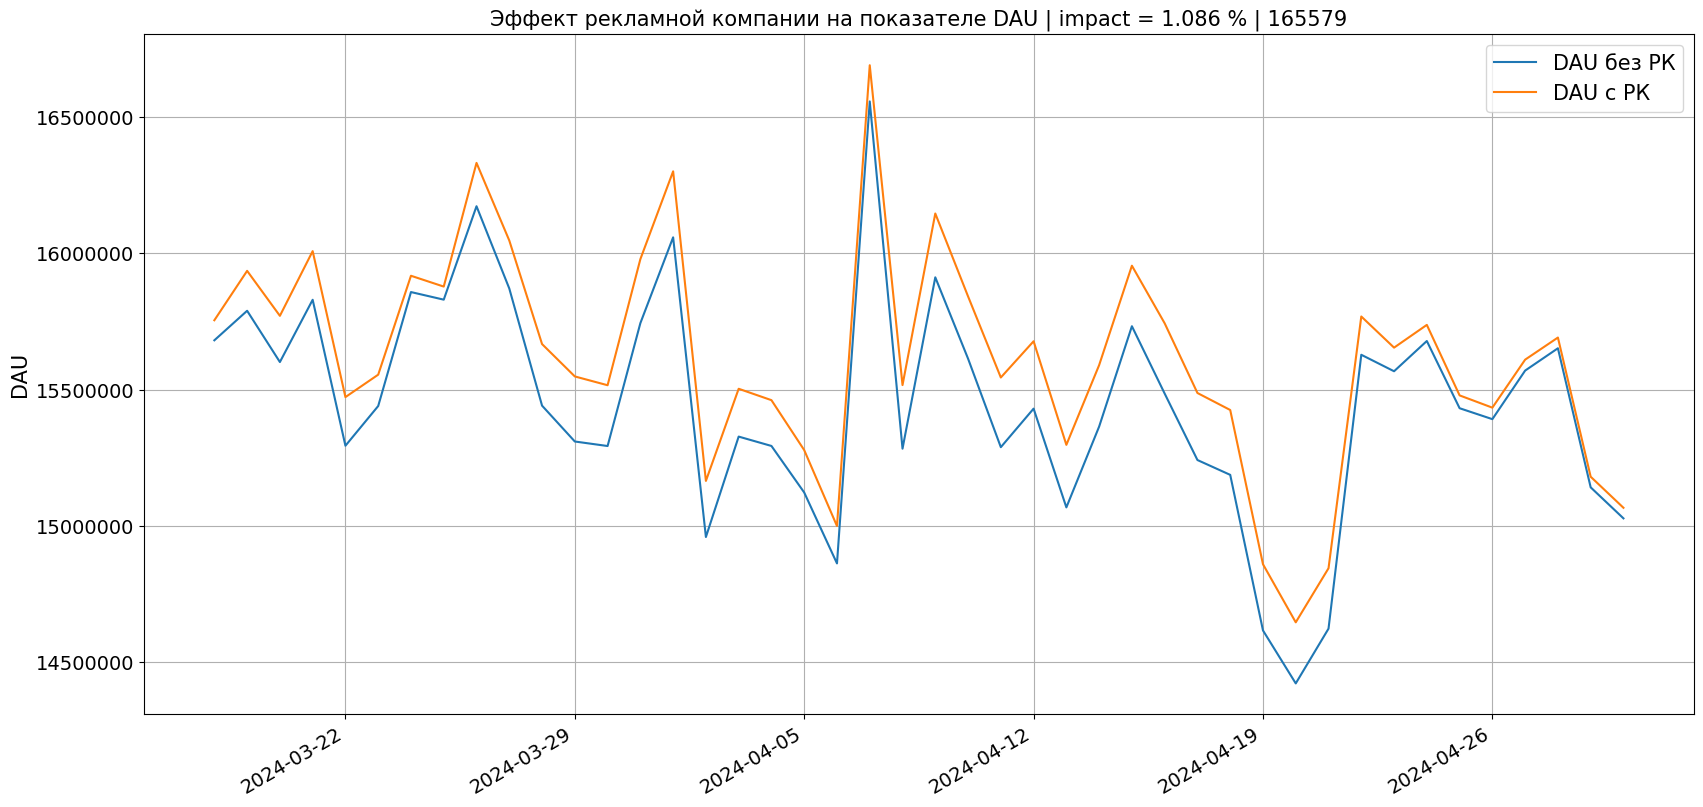

In [32]:
imp_per = round(res_media['add_impact_%'].loc['media_total'],3)
df['media_total'] = df[['digital_media_ots','bloggers_ots', 'tv_ots','ooh_ots','radio_ots']].sum(axis=1)
date_start = '2024-03-18'
date_end = '2024-04-30'
kpi_wo_ad = (df[kpi] - df['media_total'] * upd_params.get('digital_media_ots'))*df['dau_runet_35_plus']*1_000_000
kpi_wo_ad = kpi_wo_ad[(kpi_wo_ad.index >= date_start)&(kpi_wo_ad.index <=date_end)]
kpi_with_add = df.loc[date_start:date_end, kpi]*df.loc[date_start:date_end, 'dau_runet_35_plus']*1_000_000
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain', useOffset=False)
plt.plot(kpi_wo_ad)
plt.plot(kpi_with_add)
plt.grid(True)
plt.title(f'Эффект рекламной компании на показателе DAU | impact = {imp_per} % | {round(kpi_with_add.mean()-kpi_wo_ad.mean())}',fontsize=15)
plt.ylabel('DAU',fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(['DAU без РК','DAU с РК'],fontsize=15)
plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=mdates.MONDAY))
plt.gcf().autofmt_xdate()
plt.show()

## Генерация бенчмарков 

In [33]:
media_costs=pd.read_excel('../actual_data.xlsx',sheet_name='budget').fillna(0)
media_costs.index = media_costs.dt
media_costs=media_costs[media_costs.dt.ge('2023-10-30')&media_costs.dt.le('2023-12-03')].iloc[:,1:]

media_budget = pd.DataFrame({'budget':media_costs.sum(),
                             'date_start':'2023-10-30',
                             'date_end':'2023-12-03'},index = media_costs.sum().index )
media_budget.index = ['digital_media_ots', 'performance_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots']
other_factors = list(X_train.columns.values)
date_start = '2023-10-30'
date_end = '2023-12-03'

In [34]:
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

res_media = media_impact_runet(df=df,
             df_flow_init=media_budget,
             media_factors=['digital_media_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots'],
             other_factors=other_factors + ['performance_ots'],
             kpi=kpi,
             runet_col = 'dau_runet_35_plus',
             model_params=upd_params)
res_media.date_start=date_start
res_media.date_end=date_end
res_media

Сценарий без РК: 15777660.7379


budget  date_start    date_end  \
digital_media_ots                   54819210.000  2023-10-30  2023-12-03   
performance_ots                      7123808.000  2023-10-30  2023-12-03   
bloggers_ots                         1940724.000  2023-10-30  2023-12-03   
tv_ots                             125147056.000  2023-10-30  2023-12-03   
ooh_ots                             49658046.000  2023-10-30  2023-12-03   
radio_ots                           12981166.000  2023-10-30  2023-12-03   
media_total                        244546202.000  2023-10-30  2023-12-03   
dau_dzen_35_plus                             NaN  2023-10-30  2023-12-03   
dummy_holidays                               NaN  2023-10-30  2023-12-03   
dau_youtube_35_plus                          NaN  2023-10-30  2023-12-03   
seasonality_weekly_dau                       NaN  2023-10-30  2023-12-03   
seasonality_yearly_dau                       NaN  2023-10-30  2023-12-03   
ba_spontan_perc_roll_fitted_values           NaN  2023-10-30  2023-12-03   

                                         impact          kpi  impact_%  \
digital_media_ots                     46338.293 16013457.117     0.289   
performance_ots                       76826.034 16013457.117     0.480   
bloggers_ots                           2566.730 16013457.117     0.016   
tv_ots                                65797.768 16013457.117     0.411   
ooh_ots                               68788.695 16013457.117     0.430   
radio_ots                             52270.503 16013457.117     0.326   
media_total                          235761.988 16013457.117     1.472   
dau_dzen_35_plus                   -1658586.137 16013457.117   -10.357   
dummy_holidays                        24564.334 16013457.117     0.153   
dau_youtube_35_plus                -1119065.213 16013457.117    -6.988   
seasonality_weekly_dau               353016.492 16013457.117     2.204   
seasonality_yearly_dau               569927.951 16013457.117     3.559   
ba_spontan_perc_roll_fitted_values 18161574.966 16013457.117   113.415   

                                    add_impact_%    CPA  
digital_media_ots                          0.294 33.801  
performance_ots                            0.487  2.649  
bloggers_ots                               0.016 21.603  
tv_ots                                     0.417 54.343  
ooh_ots                                    0.436 20.625  
radio_ots                                  0.331  7.096  
media_total                                1.494 29.636  
dau_dzen_35_plus                         -10.512    NaN  
dummy_holidays                             0.156    NaN  
dau_youtube_35_plus                       -7.093    NaN  
seasonality_weekly_dau                     2.237    NaN  
seasonality_yearly_dau                     3.612    NaN  
ba_spontan_perc_roll_fitted_values       115.109    NaN

In [36]:
media_costs=pd.read_excel('../actual_data.xlsx',sheet_name='budget').fillna(0)
media_costs.index = media_costs.dt
media_costs=media_costs[media_costs.dt.ge('2023-03-20')&media_costs.dt.le('2023-04-23')].iloc[:,1:]

media_budget = pd.DataFrame({'budget':media_costs.sum(),
                             'date_start':'2023-03-20',
                             'date_end':'2023-04-23'},index = media_costs.sum().index )
media_budget.index = ['digital_media_ots', 'performance_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots']
other_factors = list(X_train.columns.values)
date_start = '2023-03-20'
date_end = '2023-04-23'

In [37]:
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.3f}'.format)

res_media = media_impact_runet(df=df,
             df_flow_init=media_budget,
             media_factors=['digital_media_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots'],
             other_factors=other_factors + ['performance_ots'],
             kpi=kpi,
             runet_col = 'dau_runet_35_plus',
             model_params=upd_params)
res_media.date_start=date_start
res_media.date_end=date_end
res_media

Сценарий без РК: 15995048.5373


budget  date_start    date_end  \
digital_media_ots                   36835432.000  2023-03-20  2023-04-23   
performance_ots                      5610098.000  2023-03-20  2023-04-23   
bloggers_ots                         1210417.000  2023-03-20  2023-04-23   
tv_ots                             125983693.000  2023-03-20  2023-04-23   
ooh_ots                             48667779.000  2023-03-20  2023-04-23   
radio_ots                           10085178.000  2023-03-20  2023-04-23   
media_total                        222782499.000  2023-03-20  2023-04-23   
dau_dzen_35_plus                             NaN  2023-03-20  2023-04-23   
dummy_holidays                               NaN  2023-03-20  2023-04-23   
dau_youtube_35_plus                          NaN  2023-03-20  2023-04-23   
seasonality_weekly_dau                       NaN  2023-03-20  2023-04-23   
seasonality_yearly_dau                       NaN  2023-03-20  2023-04-23   
ba_spontan_perc_roll_fitted_values           NaN  2023-03-20  2023-04-23   

                                         impact          kpi  impact_%  \
digital_media_ots                     42711.209 16204858.747     0.264   
performance_ots                       90745.712 16204858.747     0.560   
bloggers_ots                           2610.528 16204858.747     0.016   
tv_ots                                54453.804 16204858.747     0.336   
ooh_ots                               62298.536 16204858.747     0.384   
radio_ots                             47426.475 16204858.747     0.293   
media_total                          209500.553 16204858.747     1.293   
dau_dzen_35_plus                   -1699300.530 16204858.747   -10.486   
dummy_holidays                        23700.657 16204858.747     0.146   
dau_youtube_35_plus                 -713242.511 16204858.747    -4.401   
seasonality_weekly_dau               340604.491 16204858.747     2.102   
seasonality_yearly_dau               513219.266 16204858.747     3.167   
ba_spontan_perc_roll_fitted_values 17556741.553 16204858.747   108.343   

                                    add_impact_%    CPA  
digital_media_ots                          0.267 24.641  
performance_ots                            0.567  1.766  
bloggers_ots                               0.016 13.248  
tv_ots                                     0.340 66.103  
ooh_ots                                    0.390 22.320  
radio_ots                                  0.296  6.076  
media_total                                1.310 30.383  
dau_dzen_35_plus                         -10.624    NaN  
dummy_holidays                             0.148    NaN  
dau_youtube_35_plus                       -4.459    NaN  
seasonality_weekly_dau                     2.129    NaN  
seasonality_yearly_dau                     3.209    NaN  
ba_spontan_perc_roll_fitted_values       109.764    NaN

### **Проверим остатки на случайность**

Тест Бройша-Годфри на автокорреляцию остатков:

p-значение LM статистики: 0.0
Присутствует автокорреляция в остатках.

Тест Бройша-Пагана на проверку гетероскедастичности остатков:

p-значение LM статистики: 0.0712
p-значение F-статистики: 0.0714
Отсутствует гетероскедастичность в остатках.



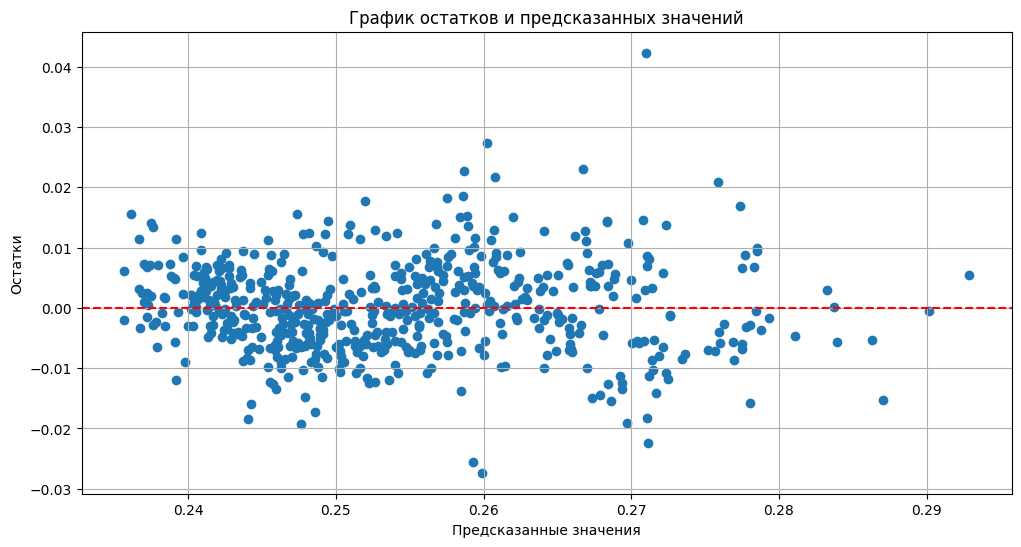

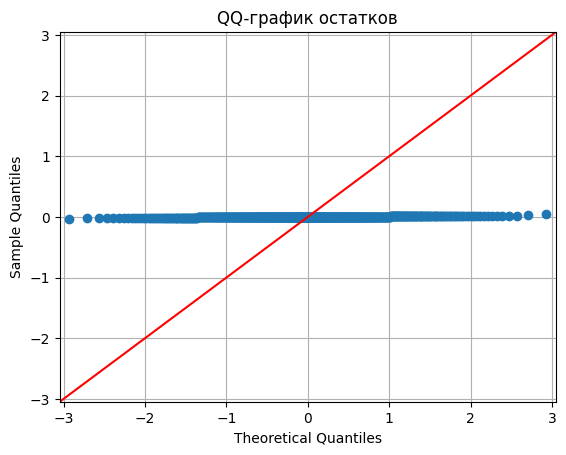

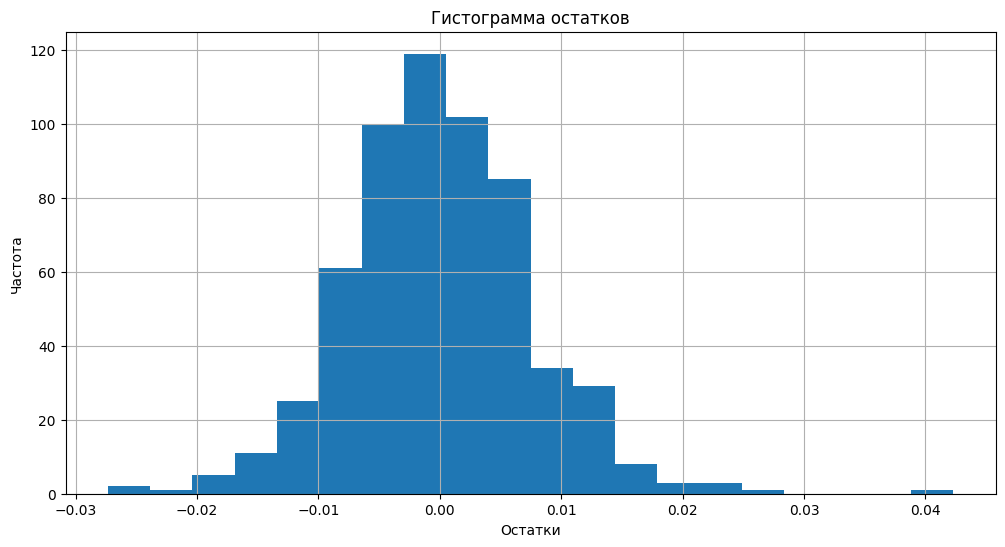

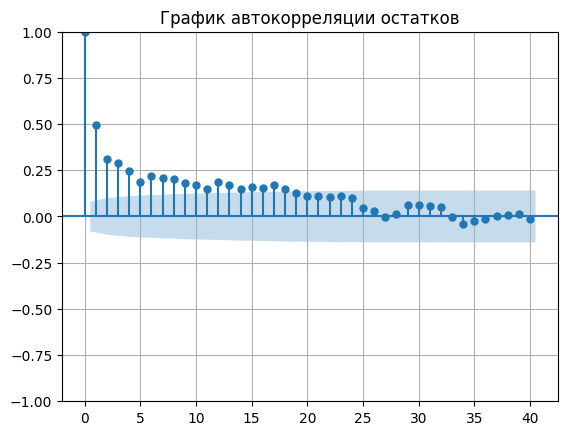

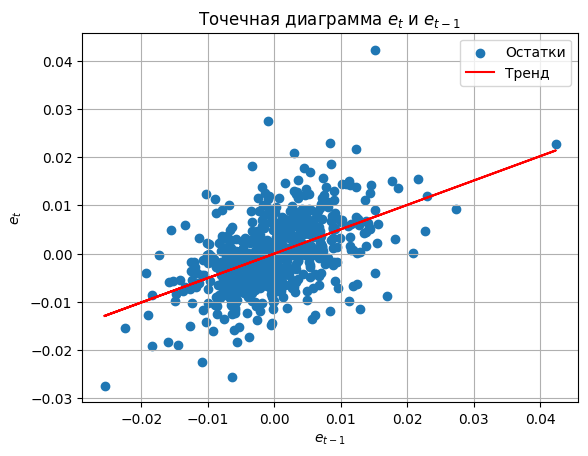

In [39]:
# Получаем остатки
residuals = model.resid


print('Тест Бройша-Годфри на автокорреляцию остатков:\n')
lag = 1  # Задаем количество лагов для теста
results = acorr_breusch_godfrey(model, nlags=lag)
print("p-значение LM статистики:", round(results[1],4))

# Проверка значимости
if results[1] < 0.05:
    print("Присутствует автокорреляция в остатках.\n")
else:
    print("Отсутствует автокорреляция в остатках.\n")

print('Тест Бройша-Пагана на проверку гетероскедастичности остатков:\n')
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, sm.add_constant(X_train['ba_spontan_perc_roll_fitted_values']))
print("p-значение LM статистики:", round(lm_pvalue,4))
print("p-значение F-статистики:", round(f_pvalue,4))

# Проверка значимости
if lm_pvalue < 0.05:
    print("Присутствует гетероскедастичность в остатках.\n")
else:
    print("Отсутствует гетероскедастичность в остатках.\n")


# График остатков vs. предсказанные значения
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков и предсказанных значений')
plt.grid(True)
plt.show()

# QQ-график
sm.qqplot(residuals, line='45')
plt.title('QQ-график остатков')
plt.grid(True)
plt.show()

# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=20)
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)
plt.show()

# График автокорреляции остатков
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('График автокорреляции остатков')
plt.grid(True)
plt.show()

# график остатков от лага
residuals_t_1 = residuals.shift(1).fillna(0)
# построим линию тренда 
e_t_1 = residuals_t_1.values.reshape(-1, 1)
e_t = residuals.values

# Обучаем модель линейной регрессии
linear_trend = LinearRegression()
linear_trend.fit(e_t_1, e_t)

# Предсказываем значения на основе модели
y_pred = linear_trend.predict(e_t_1)

plt.scatter(residuals_t_1, residuals)
plt.plot(residuals_t_1,y_pred,color='red')
plt.title('Точечная диаграмма $e_t$ и $e_{t-1}$')
plt.xlabel('$e_{t-1}$')
plt.ylabel('$e_{t}$')
plt.legend(['Остатки','Тренд'])
plt.grid(True)


## **Второй подход с очищением BA от медиа-активаций**

In [40]:
non_media_final_factors = ['dau_dzen_35_plus',
                           'dummy_holidays',
                           'dau_youtube_35_plus',
                           #'product_performance_ots',
                           #'product_activity_piar_ots',
                           # 'dummy_show_bur',
                           #'dau_instagram_35_plus',
                           'seasonality_weekly_dau',
                           #'trend_prophet_dau',
                           'seasonality_yearly_dau',
                          # 'wordstat_num_of_queries',
                           #'aa_spontan_perc_roll_adj',
                           'media_total_ots',
                           'ba_spontan_perc_roll_adj_wo_media']
                           #'consid_spontan_perc_roll_adj'
                           # 'ws_perc_of_total_queries',
                           #'aa_prompted_kpi_percent_ttl_roll'

model_factors = non_media_final_factors # + ['total_media']
X = df[model_factors].copy()

X_train = X.head(-horizon)
y_train = y.head(-horizon)

X_test = X.tail(horizon)
y_test = y.tail(horizon)

X_train = X_train.reindex(y_train.index)

In [41]:
np.set_printoptions(suppress=True) # отключаем научную нотацию
model = sm.OLS(y_train,sm.add_constant(X_train,has_constant='add')).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})

results_summary = model.summary()
print(results_summary)

# Рассчитываем прогноз
forecast = model.get_prediction(sm.add_constant(X_test,has_constant='add'))

# Точечный рогноз
forecast_values = forecast.predicted_mean
# Интервальный прогноз (доверительный интервал)
forecast_intervals = forecast.conf_int()
print(f'Линейная регрессия от total_media\nМетрики на тестовой выборке:\nSMAPE:{round(SMAPE(forecast_values,y_test),3)}\nWAPE:{round(WAPE(forecast_values,y_test),3)}\nRMSE:{round(RMSE(forecast_values,y_test),3)}')
res['additive_2mnk_linear_reg_2'] = round(WAPE(forecast_values,y_test),3), round(SMAPE(forecast_values,y_test),3),round(RMSE(forecast_values,y_test),3)

                               OLS Regression Results                              
Dep. Variable:     dau_ok_35_plus_relative   R-squared:                       0.715
Model:                                 OLS   Adj. R-squared:                  0.711
Method:                      Least Squares   F-statistic:                     158.0
Date:                     Mon, 10 Jun 2024   Prob (F-statistic):          4.29e-130
Time:                             14:51:39   Log-Likelihood:                 2083.6
No. Observations:                      590   AIC:                            -4151.
Df Residuals:                          582   BIC:                            -4116.
Df Model:                                7                                         
Covariance Type:                       HAC                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------

**Сравнение прогноза с фактом**

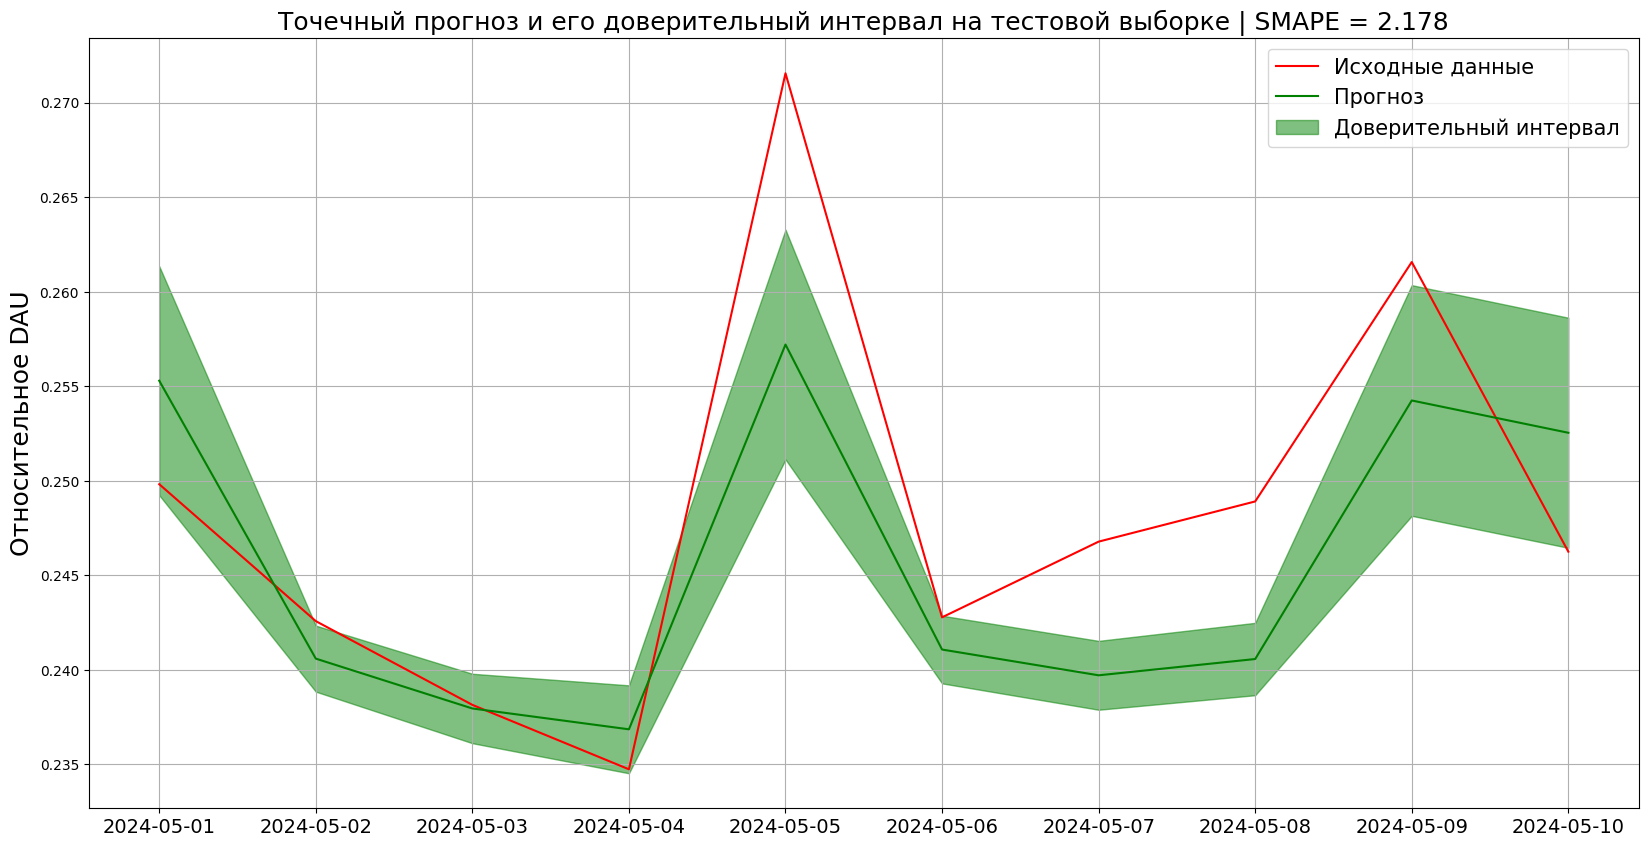

In [42]:
plt.figure(figsize=(20, 10))

# График исходных данных
plt.plot(y_test.index, y_test, label='Исходные данные', color='red')

# График предсказанных значений
plt.plot(y_test.index, forecast_values, color='green', label='Прогноз')

# # График доверительного интервала
plt.fill_between(y_test.index, forecast_intervals[:, 0], forecast_intervals[:, 1], color='green', alpha=0.5, label='Доверительный интервал')

plt.ylabel('Относительное DAU', fontsize=18)
plt.xticks(fontsize=14)
plt.title(f'Точечный прогноз и его доверительный интервал на тестовой выборке | SMAPE = {round(SMAPE(forecast_values,y_test),3)}', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)

# plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=mdates.MONDAY))
# plt.gcf().autofmt_xdate()

plt.show()

**Декомпозиция**

In [43]:
plot_decomposition(pd.concat([sm.add_constant(X_train[model_factors]),y_train],axis=1),model,kpi_name=kpi)

**Вклад медиа-активностей в DAU**

In [44]:
upd_params = pd.Series({'const':model.params.get('const'),
                      'digital_media_ots':model.params.get('media_total_ots'),
                      'performance_ots':model.params.get('media_total_ots'),
                      'bloggers_ots':model.params.get('media_total_ots'),
                      'tv_ots':model.params.get('media_total_ots'),
                      'ooh_ots':model.params.get('media_total_ots'),
                      'radio_ots':model.params.get('media_total_ots'),
                      'dau_dzen_35_plus':model.params.get('dau_dzen_35_plus'),
                      'dummy_holidays':model.params.get('dummy_holidays'),
                      'dau_youtube_35_plus':model.params.get('dau_youtube_35_plus'),
                      'seasonality_weekly_dau':model.params.get('seasonality_weekly_dau'),
                      'seasonality_yearly_dau':model.params.get('seasonality_yearly_dau'),
                      'ba_spontan_perc_roll_adj_wo_media':model.params.get('ba_spontan_perc_roll_adj_wo_media')})

In [45]:
other_factors = ['const','dau_dzen_35_plus', 'dummy_holidays', 'dau_youtube_35_plus',
                 'seasonality_weekly_dau', 'seasonality_yearly_dau',
                 'ba_spontan_perc_roll_adj_wo_media','performance_ots']

In [46]:
df['const']=1

In [47]:
media_costs=pd.read_excel('../actual_data.xlsx',sheet_name='budget').fillna(0)
media_costs.index = media_costs.dt
media_costs=media_costs[media_costs.dt.ge('2024-03-18')&media_costs.dt.le('2024-04-30')].iloc[:,1:]

In [48]:
media_budget = pd.DataFrame({'budget':media_costs.sum(),
                             'date_start':'2024-03-18',
                             'date_end':'2024-04-30'},index = media_costs.sum().index )
media_budget.index = ['digital_media_ots', 'performance_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots']

In [49]:
warnings.filterwarnings('ignore')
res_media = media_impact_runet(df=df,
             df_flow_init=media_budget,
             media_factors=['digital_media_ots', 'bloggers_ots', 'tv_ots', 'ooh_ots', 'radio_ots'],
             other_factors=other_factors,
             kpi=kpi,
             runet_col='dau_runet_35_plus',
             model_params=upd_params)
res_media.date_start=date_start
res_media.date_end=date_end
res_media

Сценарий без РК: 15526189.6925


budget  date_start    date_end  \
digital_media_ots                  59533815.850  2023-03-20  2023-04-23   
performance_ots                     4122199.680  2023-03-20  2023-04-23   
bloggers_ots                        4795225.000  2023-03-20  2023-04-23   
tv_ots                                    0.000  2023-03-20  2023-04-23   
ooh_ots                            19899690.000  2023-03-20  2023-04-23   
radio_ots                          16634085.000  2023-03-20  2023-04-23   
media_total                       100862815.850  2023-03-20  2023-04-23   
const                                       NaN  2023-03-20  2023-04-23   
dau_dzen_35_plus                            NaN  2023-03-20  2023-04-23   
dummy_holidays                              NaN  2023-03-20  2023-04-23   
dau_youtube_35_plus                         NaN  2023-03-20  2023-04-23   
seasonality_weekly_dau                      NaN  2023-03-20  2023-04-23   
seasonality_yearly_dau                      NaN  2023-03-20  2023-04-23   
ba_spontan_perc_roll_adj_wo_media           NaN  2023-03-20  2023-04-23   

                                        impact          kpi  impact_%  \
digital_media_ots                    32073.562 15609555.104     0.205   
performance_ots                      19093.017 15609555.104     0.122   
bloggers_ots                          5336.823 15609555.104     0.034   
tv_ots                                   0.000 15609555.104     0.000   
ooh_ots                              13255.616 15609555.104     0.085   
radio_ots                            32756.083 15609555.104     0.210   
media_total                          83422.084 15609555.104     0.534   
const                              9817134.513 15609555.104    62.892   
dau_dzen_35_plus                  -1829405.535 15609555.104   -11.720   
dummy_holidays                       38713.983 15609555.104     0.248   
dau_youtube_35_plus                -836685.640 15609555.104    -5.360   
seasonality_weekly_dau              362919.916 15609555.104     2.325   
seasonality_yearly_dau              495754.591 15609555.104     3.176   
ba_spontan_perc_roll_adj_wo_media  7573105.420 15609555.104    48.516   

                                   add_impact_%    CPA  
digital_media_ots                         0.207 42.186  
performance_ots                           0.123  4.907  
bloggers_ots                              0.034 20.421  
tv_ots                                    0.000    NaN  
ooh_ots                                   0.085 34.119  
radio_ots                                 0.211 11.541  
media_total                               0.537 27.479  
const                                    63.230    NaN  
dau_dzen_35_plus                        -11.783    NaN  
dummy_holidays                            0.249    NaN  
dau_youtube_35_plus                      -5.389    NaN  
seasonality_weekly_dau                    2.337    NaN  
seasonality_yearly_dau                    3.193    NaN  
ba_spontan_perc_roll_adj_wo_media        48.776    NaN

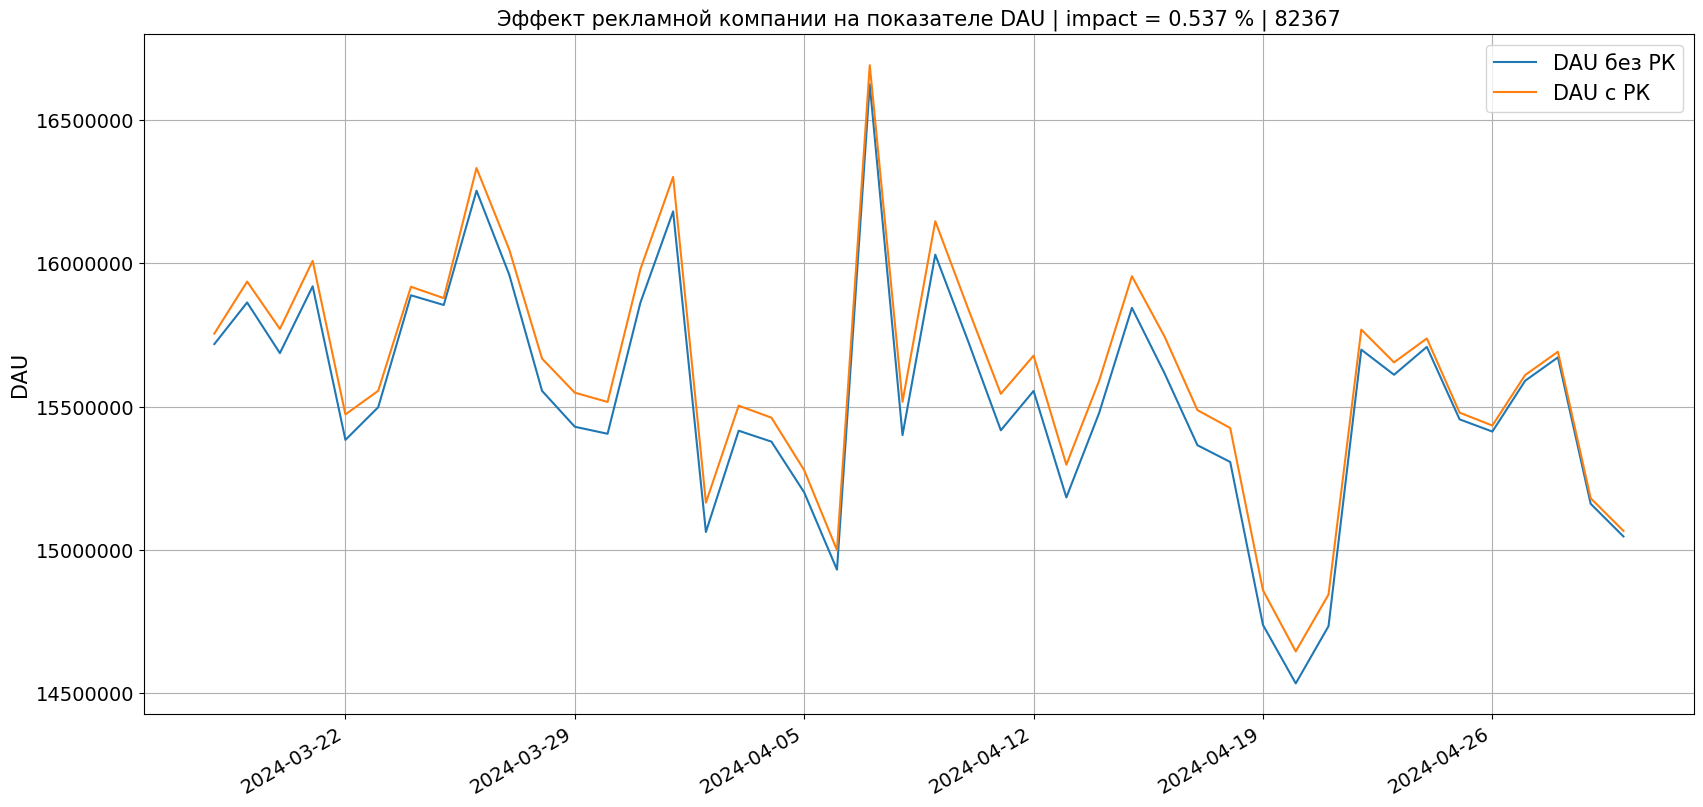

In [50]:
imp_per = round(res_media['add_impact_%'].loc['media_total'],3)
date_start = '2024-03-18'
date_end = '2024-04-30'
kpi_wo_ad = (df[kpi] - df['media_total'] * upd_params.get('digital_media_ots'))*df['dau_runet_35_plus']*1_000_000
kpi_wo_ad = kpi_wo_ad[(kpi_wo_ad.index >= date_start)&(kpi_wo_ad.index <=date_end)]
kpi_with_add = df.loc[date_start:date_end, kpi]*df.loc[date_start:date_end, 'dau_runet_35_plus']*1_000_000
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain', useOffset=False)
plt.plot(kpi_wo_ad)
plt.plot(kpi_with_add)
plt.grid(True)
plt.title(f'Эффект рекламной компании на показателе DAU | impact = {imp_per} % | {round(kpi_with_add.mean()-kpi_wo_ad.mean())}',fontsize=15)
plt.ylabel('DAU',fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(['DAU без РК','DAU с РК'],fontsize=15)
plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=mdates.MONDAY))
plt.gcf().autofmt_xdate()
plt.show()

Тест Бройша-Годфри на автокорреляцию остатков:

p-значение LM статистики: 0.0
Присутствует автокорреляция в остатках.

Тест Бройша-Пагана на проверку гетероскедастичности остатков:

p-значение LM статистики: 0.2236
p-значение F-статистики: 0.2243
Отсутствует гетероскедастичность в остатках.



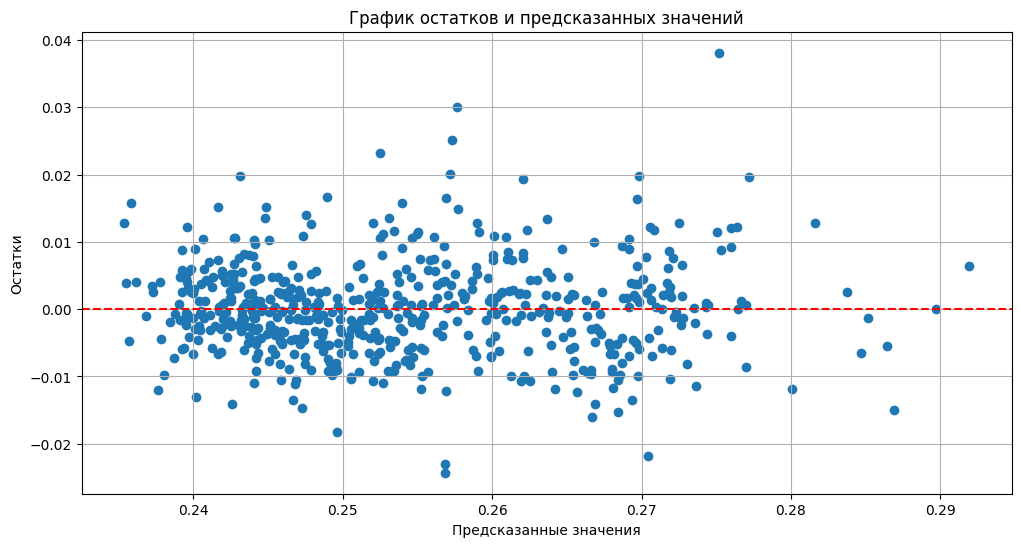

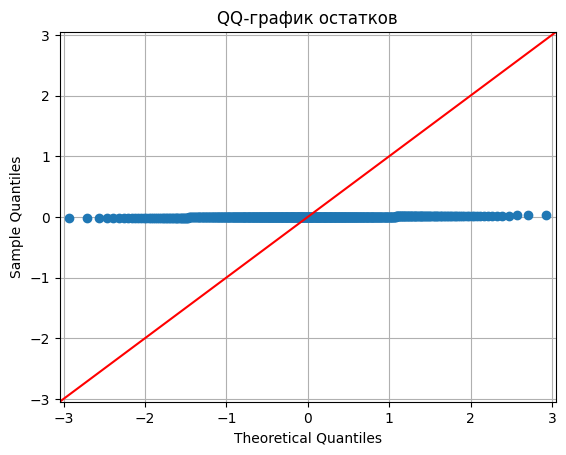

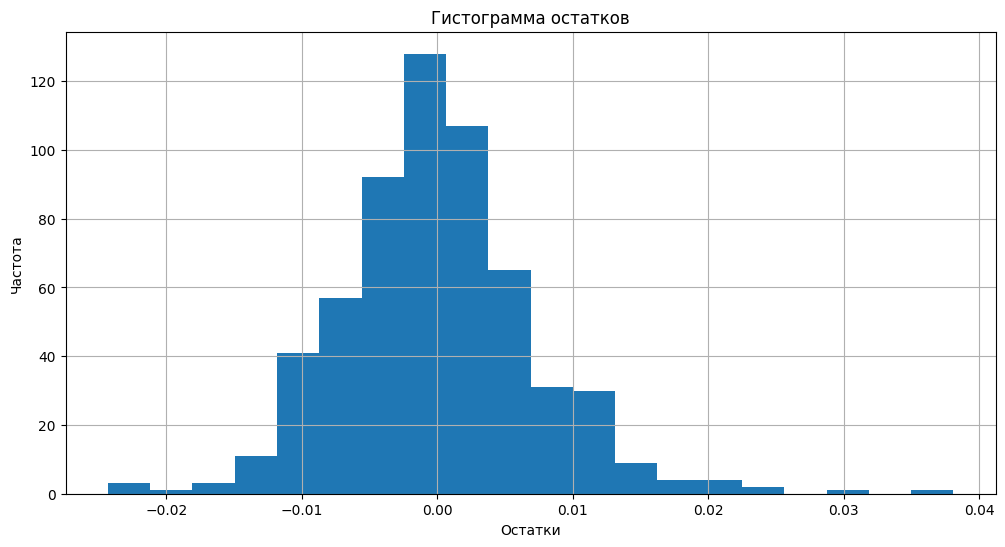

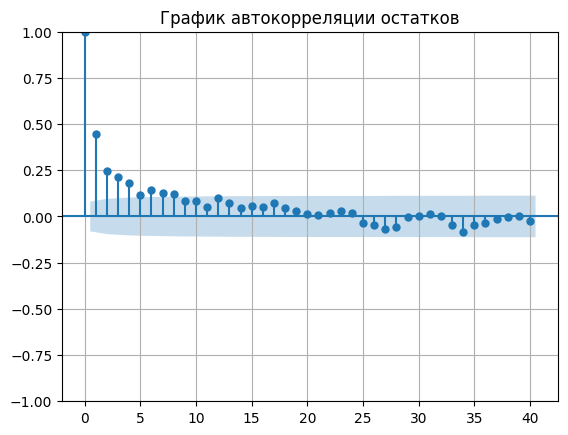

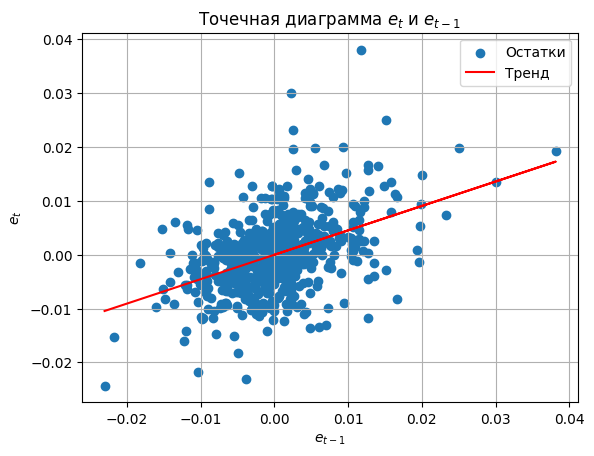

In [51]:
# Получаем остатки
residuals = model.resid

print('Тест Бройша-Годфри на автокорреляцию остатков:\n')
lag = 1  # Задаем количество лагов для теста
results = acorr_breusch_godfrey(model, nlags=lag)
print("p-значение LM статистики:", round(results[1],4))

# Проверка значимости
if results[1] < 0.05:
    print("Присутствует автокорреляция в остатках.\n")
else:
    print("Отсутствует автокорреляция в остатках.\n")

print('Тест Бройша-Пагана на проверку гетероскедастичности остатков:\n')
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(residuals, sm.add_constant(X_train['media_total_ots']))
print("p-значение LM статистики:", round(lm_pvalue,4))
print("p-значение F-статистики:", round(f_pvalue,4))

# Проверка значимости
if lm_pvalue < 0.05:
    print("Присутствует гетероскедастичность в остатках.\n")
else:
    print("Отсутствует гетероскедастичность в остатках.\n")


# График остатков vs. предсказанные значения
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('График остатков и предсказанных значений')
plt.grid(True)
plt.show()

# QQ-график
sm.qqplot(residuals, line='45')
plt.title('QQ-график остатков')
plt.grid(True)
plt.show()

# Гистограмма остатков
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=20)
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)
plt.show()

# График автокорреляции остатков
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title('График автокорреляции остатков')
plt.grid(True)
plt.show()

# график остатков от лага
residuals_t_1 = residuals.shift(1).fillna(0)
# построим линию тренда 
e_t_1 = residuals_t_1.values.reshape(-1, 1)
e_t = residuals.values

# Обучаем модель линейной регрессии
linear_trend = LinearRegression()
linear_trend.fit(e_t_1, e_t)

# Предсказываем значения на основе модели
y_pred = linear_trend.predict(e_t_1)

plt.scatter(residuals_t_1, residuals)
plt.plot(residuals_t_1,y_pred,color='red')
plt.title('Точечная диаграмма $e_t$ и $e_{t-1}$')
plt.xlabel('$e_{t-1}$')
plt.ylabel('$e_{t}$')
plt.legend(['Остатки','Тренд'])
plt.grid(True)


### **Мультипликативный эффект от total_media**

$$ln(1+kpi_t) = b_0 +b_1\cdot ln(1+TV_t +  OOH_t + Digital_t + Perform_t + Bloggers_t) + b_2\cdot X_2 + e_t$$
$$ln(1+kpi_t) = b_0 +b_1\cdot ln(1+totalmedia_t) + b_2\cdot X_2 + e_t$$

$$1+kpi_t = e^{b_0}\cdot (1+totalmedia_t)^{b_1}\cdot e^{b_2\cdot X_2}$$

**Выделим эффект от медиа следующим образом:**

Обозначим для удоства восприятия

$y_t=1+kpi_t$, 

$x_t =1+totalmedia_t$

Доля объясненной дисперсии (вклад) фактора $x$ в дисперсию зависимой переменной $y$ рассчитывается как квадрат корреляции между $ln(y)$ и $ln(x)$:

$impact(x_t) = corr(ln(y_t),ln(x_t))^2$ - доля объясненной дисперсии (вклад) фактора x в дисперсию зависимой переменной y

Для удобства обозначим 

$\widetilde y_t = ln(y_t)$,

$\widetilde x_t = ln(x_t)$


Вспомним, что коэффициент $b_1$ (можно вывести из парной регрессии с помощью МНК ) представляет собой следующее:

$b_1 = \frac{cov(\widetilde x,\widetilde y)}{\sigma^2(\widetilde x)}$

$\Rightarrow$ $corr(\widetilde y_t,\widetilde x_t)^2 = (\frac{cov(\widetilde x,\widetilde y)}{\sigma(\widetilde x)\cdot \sigma(\widetilde y)})^2=(\frac{cov(\widetilde x,\widetilde y)}{\sigma(\widetilde x)\cdot \sigma(\widetilde y)}\cdot \frac{\sigma(\widetilde x)}{\sigma(\widetilde x)})^2=(b_1\cdot \frac{\sigma(\widetilde x)}{\sigma(\widetilde y)})^2$ - вклад медиа в продуктовую метрику (в долях)

где $\sigma(\widetilde x)$ - стандартное отклонение логарифма x

$\sigma(\widetilde y)$ - стандартное отклонение логарифма y

In [52]:
df['media_total_ots_multi'] = np.log1p(df.media_total_ots)
non_media_final_factors=['dau_dzen_35_plus',
                           'dummy_holidays',
                           #'dau_youtube_35_plus',
                           #'product_perform',
                           #'product_activity_piar',
                           'seasonality_weekly_dau',
                           #'trend_prophet_dau',
                           'seasonality_yearly_dau',
                           # 'wordstat_num_of_queries',
                           'ba_spontaneous_kpi_percent_ttl_roll']
model_factors_ = non_media_final_factors + ['media_total_ots_multi']
X = df[model_factors_].copy()

X_train = X.head(-horizon)
y_train = np.log1p(y.head(-horizon))

X_test = X.tail(horizon)
y_test = np.log1p(y.tail(horizon))
X_train = X_train.reindex(y_train.index)

In [53]:
np.set_printoptions(suppress=True) # отключаем научную нотацию 
model = sm.OLS(y_train,sm.add_constant(X_train,has_constant='add')).fit(cov_type='HAC', cov_kwds={'maxlags': lag_value})

results_summary = model.summary2()
print(results_summary)

# Рассчитываем прогноз
forecast = model.get_prediction(sm.add_constant(X_test,has_constant='add'))

# Точечный рогноз
forecast_values = forecast.predicted_mean
# Интервальный прогноз (доверительный интервал)
forecast_intervals = forecast.conf_int()

multi_smape = round(SMAPE(np.exp(forecast_values)-1,np.exp(y_test)-1),3)
multi_wape = round(WAPE(np.exp(forecast_values)-1,np.exp(y_test)-1),3)
multi_rmse = round(RMSE(np.exp(forecast_values)-1,np.exp(y_test)-1),3)
print(f'Линейная регрессия от медиа-факторов:\nSMAPE:{multi_smape}\nWAPE:{multi_wape}\nRMSE:{multi_rmse}')
res['multi_linear_reg'] = multi_wape,multi_smape,multi_rmse

                          Results: Ordinary least squares
Model:                  OLS                        Adj. R-squared:        0.691     
Dependent Variable:     dau_ok_35_plus_relative    AIC:                   -4383.6787
Date:                   2024-06-10 14:51           BIC:                   -4353.0179
No. Observations:       590                        Log-Likelihood:        2198.8    
Df Model:               6                          F-statistic:           162.5     
Df Residuals:           583                        Prob (F-statistic):    5.91e-121 
R-squared:              0.694                      Scale:                 3.4325e-05
------------------------------------------------------------------------------------
                                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------
const                                0.1022   0.0155   6.6099 0.0000  0.0719  0.1325
dau_dze

In [54]:
model_features = list(model.params.index)
sigma_y = y_train.loc[date_start:date_end].std()
impacts = {}

sigma_y_train = y_train.std()
impacts_train = {}
for col in model_features:
    sigma_x = sm.add_constant(X_train).loc[date_start:date_end,col].std()
    impact = 100*(model.params.get(col)*sigma_x/sigma_y)**2
    impacts[col] = impact

    sigma_x_train = sm.add_constant(X_train).loc[:,col].std()
    impact_train = 100*(model.params.get(col)*sigma_x_train/sigma_y_train)**2
    impacts_train[col] = impact_train

media_imp = impacts.get('media_total_ots_multi')
media_imp_train = impacts_train.get('media_total_ots_multi')

print(f'Вклад медиа-активностей в дисперсию зависимой переменной во время РК: {round(media_imp,3)} %')
print(f'Вклад медиа-активностей в дисперсию зависимой переменной на всей обучающей выборке: {round(media_imp_train,3)} %')

Вклад медиа-активностей в дисперсию зависимой переменной во время РК: 0.136 %
Вклад медиа-активностей в дисперсию зависимой переменной на всей обучающей выборке: 0.054 %


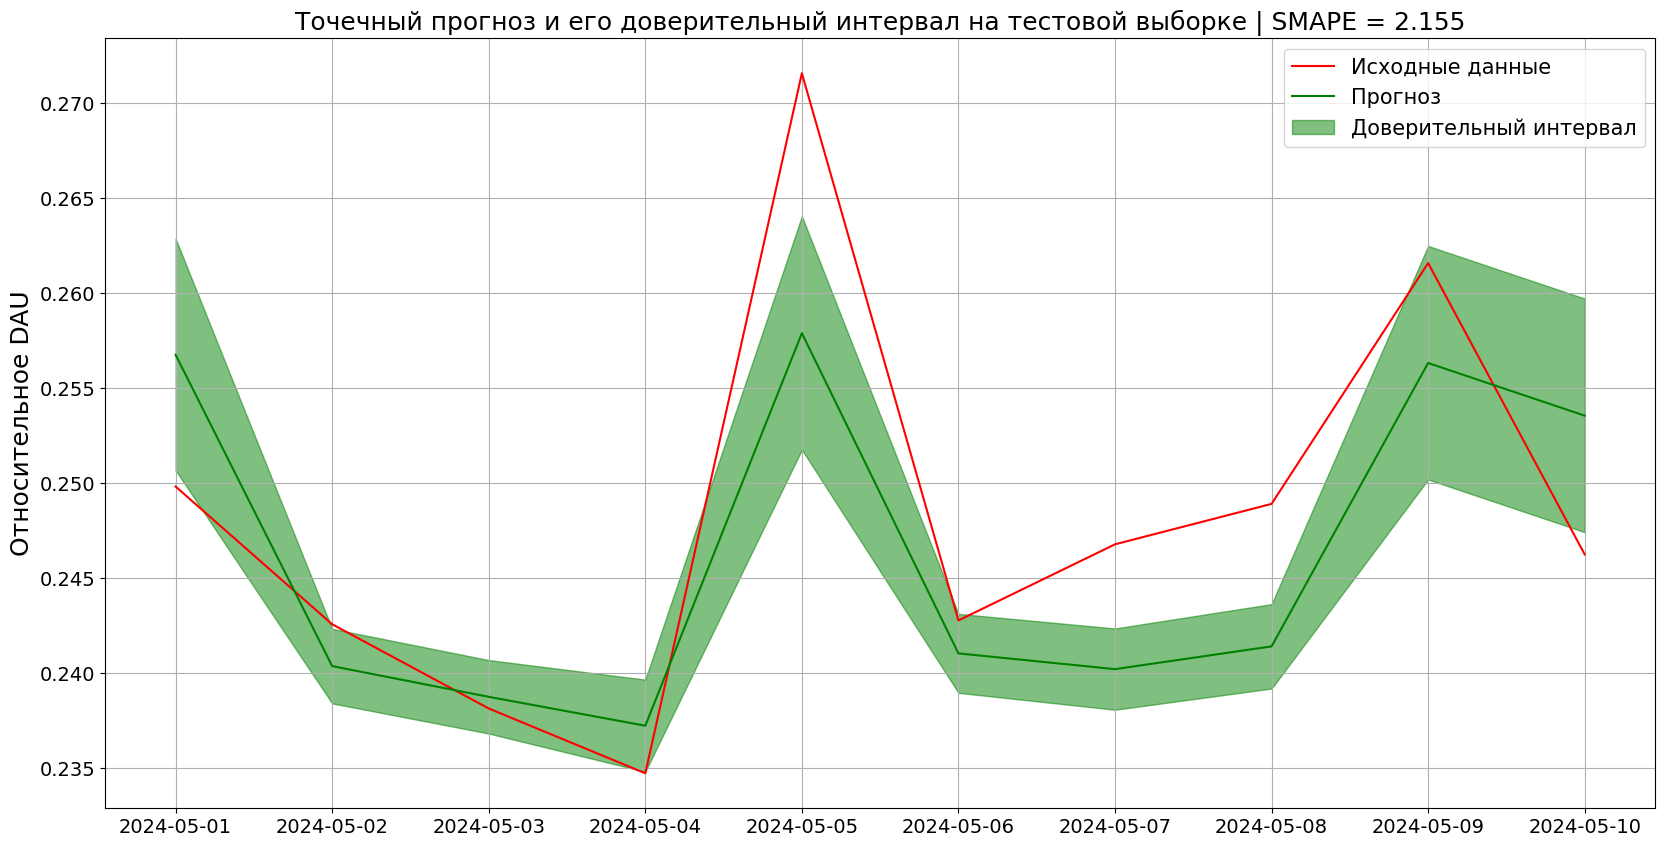

In [55]:
plt.figure(figsize=(20, 10))

# График исходных данных
plt.plot(y_test.index, np.exp(y_test)-1, label='Исходные данные', color='red')

# График предсказанных значений
plt.plot(y_test.index, np.exp(forecast_values)-1, color='green', label='Прогноз')

# # График доверительного интервала
plt.fill_between(y_test.index, np.exp(forecast_intervals[:, 0])-1, np.exp(forecast_intervals[:, 1])-1, color='green', alpha=0.5, label='Доверительный интервал')

plt.ylabel('Относительное DAU', fontsize=18)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f'Точечный прогноз и его доверительный интервал на тестовой выборке | SMAPE = {multi_smape}', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)

# plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=mdates.MONDAY))
# plt.gcf().autofmt_xdate()

plt.show()

In [56]:
plot_decomposition(pd.concat([sm.add_constant(X_train),y_train],axis=1),model,kpi_name=kpi)

In [57]:
upd_params = pd.Series({'const':model.params.get('const'),
                      'media_total_ots_multi':model.params.get('media_total_ots_multi'),
                      'dau_dzen_35_plus':model.params.get('dau_dzen_35_plus'),
                      'dummy_holidays':model.params.get('dummy_holidays'),
                      'seasonality_weekly_dau':model.params.get('weekly_seasonality_dau'),
                      'seasonality_yearly_dau':model.params.get('yearly_seasonality_dau'),
                      # 'wordstat_num_of_queries':model.params.get('ws_num_of_queries'),
                      'ba_spontaneous_kpi_percent_ttl_roll':model.params.get('ba_spontaneous_kpi_percent_ttl_roll')})

In [58]:
other_factors =  ['const','dau_dzen_35_plus','dummy_holidays','seasonality_weekly_dau',
                 'seasonality_yearly_dau','ba_spontaneous_kpi_percent_ttl_roll']

In [59]:
def impact_runet(df: pd.DataFrame,
                 df_flow_init: pd.DataFrame,
                 media_factors: List[str], 
                 other_factors: List[str], 
                 kpi: str,
                 model_params: pd.Series,
                 avg_over_period=True):

    """
    Counts impact and CPA for each media factor.
    Before using this function, you should create a dataframe with special structure
    and pass it as an argument to the function.

    Args:
        df (pd.DataFrame): DataFrame containing existing media parameters.
        df_flow_init (pd.DataFrame): DataFrame containing periods and budget for each media channel.
        media_factors (List): List containing media factors by which the total impact should be calculated.
        other_factors (List): List containing other factors.
        kpi (str): The name of the kpi.
        model_params (pd.Series): Model coefficients for each factor.

    Returns:
        pd.DataFrame: DataFrame containing the impacts and CPA for each factor.
        
    """
    def agg_func(x):
        if avg_over_period:
            return(np.mean(x, axis=0))
        else:
            return(np.sum(x, axis=0))
        
    df_flow = df_flow_init.copy()
    # df_flow['date_start'] = pd.to_datetime(df_flow['date_start'])
    # df_flow['date_end'] = pd.to_datetime(df_flow['date_end'])
    
    date_start = df_flow['date_start'][0]
    date_end = df_flow['date_end'][0]
    
    df['Kpi_wo_ad'] = (np.exp((df[kpi] - (df[media_factors] * model_params.get(media_factors)).sum(axis=1)))-1)*df['dau_runet_35_plus']*1_000_000

    for col in ([*media_factors] + [*other_factors]):
        date_start = df_flow['date_start'][0]
        date_end = df_flow['date_end'][0]
        df_flow.loc[col, 'kpi'] = agg_func(df.loc[date_start:date_end, kpi])*agg_func(df.loc[date_start:date_end, 'dau_runet_35_plus'])*1_000_000
        
        df_flow.loc[col, 'impact'] = agg_func(df.loc[date_start:date_end, col]*model_params.get(col))*agg_func(df.loc[date_start:date_end, 'dau_runet_35_plus'])*1_000_000
            
        df_flow.loc[col, 'impact_%'] = df_flow.loc[col, 'impact'] / df_flow.loc[col, 'kpi'] * 100
        df_flow.loc[col, 'add_impact_%'] = df_flow.loc[col, 'impact'] /\
                                           agg_func(df.loc[date_start:date_end, 'Kpi_wo_ad']) * 100
        df_flow.loc[col, 'CPA'] = (df_flow.loc[col, 'budget']/\
                                   np.where(avg_over_period, (pd.to_datetime(date_end)- pd.to_datetime(date_start)).days+1, 1)) /\
                                   df_flow.loc[col, 'impact']  # потому что доля DAU от рунета                
    print('Сценарий без РК:', round(agg_func(df.loc[date_start:date_end, 'Kpi_wo_ad']), 4))

    df_flow['kpi'] = agg_func(np.exp(df.loc[date_start:date_end, kpi])-1)*agg_func(df.loc[date_start:date_end, 'dau_runet_35_plus'])*1_000_000
    df_flow=df_flow.drop(columns='impact')
    return round(df_flow, 4)

In [60]:
data_train = pd.concat([X_train,y_train,df.loc[:'2024-04-30','dau_runet_35_plus']],axis=1)
data_train['const'] = 1 

In [61]:
total_media_budget = pd.DataFrame(media_budget.iloc[-1,:]).T
total_media_budget=pd.DataFrame(total_media_budget.iloc[-1].rename('media_total_ots_multi')).T
warnings.filterwarnings('ignore')
res_media = impact_runet(df=data_train,
             df_flow_init=total_media_budget,
             media_factors=['media_total_ots_multi'],
             other_factors=other_factors,
             kpi=kpi,
             model_params=upd_params)
res_media.date_start = date_start
res_media.date_end = date_end
res_media

Сценарий без РК: 15557056.4393


budget  date_start    date_end  \
media_total_ots_multi               16634085.000  2024-03-18  2024-04-30   
const                                        NaN  2024-03-18  2024-04-30   
dau_dzen_35_plus                             NaN  2024-03-18  2024-04-30   
dummy_holidays                               NaN  2024-03-18  2024-04-30   
seasonality_weekly_dau                       NaN  2024-03-18  2024-04-30   
seasonality_yearly_dau                       NaN  2024-03-18  2024-04-30   
ba_spontaneous_kpi_percent_ttl_roll          NaN  2024-03-18  2024-04-30   

                                             kpi  impact_%  add_impact_%   CPA  
media_total_ots_multi               15612847.684     0.322         0.290 8.391  
const                               15612847.684    47.478        42.703   NaN  
dau_dzen_35_plus                    15612847.684   -13.683       -12.306   NaN  
dummy_holidays                      15612847.684     0.224         0.201   NaN  
seasonality_weekly_dau              15612847.684       NaN           NaN   NaN  
seasonality_yearly_dau              15612847.684       NaN           NaN   NaN  
ba_spontaneous_kpi_percent_ttl_roll 15612847.684    62.137        55.887   NaN

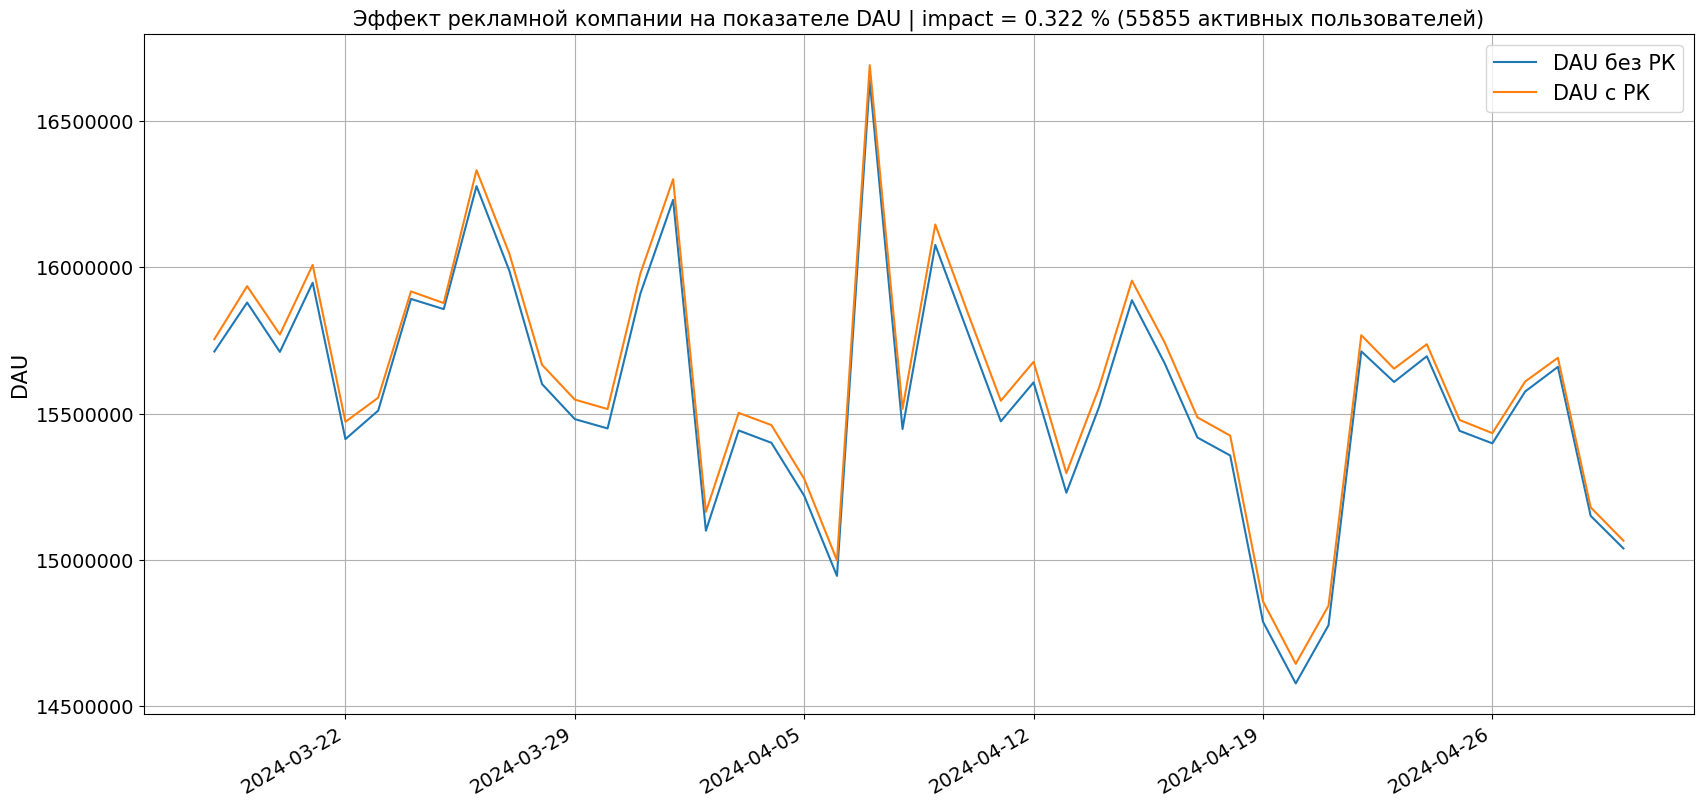

In [62]:
imp_per = res_media['impact_%'].loc['media_total_ots_multi']
date_start = '2024-03-18'
date_end = '2024-04-30'
kpi_wo_ad = (np.exp((y_train - df['media_total_ots_multi'] * upd_params.get('media_total_ots_multi')))-1)*df['dau_runet_35_plus']*1_000_000
kpi_wo_ad = kpi_wo_ad[(kpi_wo_ad.index >= date_start)&(kpi_wo_ad.index <=date_end)]
kpi_with_add = (np.exp(y_train.loc[date_start:date_end])-1)*df.loc[date_start:date_end, 'dau_runet_35_plus']*1_000_000
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain', useOffset=False)
plt.plot(kpi_wo_ad)
plt.plot(kpi_with_add)
plt.grid(True)
plt.title(f'Эффект рекламной компании на показателе DAU | impact = {imp_per} % ({round(kpi_with_add.mean()-kpi_wo_ad.mean())} активных пользователей)',fontsize=15)
plt.ylabel('DAU',fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(['DAU без РК','DAU с РК'],fontsize=15)
plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=mdates.MONDAY))
plt.gcf().autofmt_xdate()
plt.show()

## **1. Prophet**

**Будем прогнозировать на 2 месяца вперед (~60 точек)**

In [63]:
data = df.reset_index().rename(columns={'dt':'ds',kpi:'y','dummy_holidays':'holiday','trend':'trend_prothet_dau'}).copy()
data.reset_index(drop=True,inplace=True)

In [64]:
numeric_features = ['media_total_ots','dau_dzen_35_plus','dau_youtube_35_plus']
data = data[numeric_features + ['ds','y']]
data['ds'] = pd.to_datetime(data.ds)

In [65]:
model = Prophet(seasonality_mode = 'additive',
                changepoint_prior_scale=0.5,
                yearly_seasonality=1,
                weekly_seasonality=1,
                seasonality_prior_scale=20)
# Добавление факторов
for i in numeric_features:
    model.add_regressor(i)
# Обучение модели
model.fit(data[:-horizon])

14:51:41 - cmdstanpy - INFO - Chain [1] start processing
14:51:41 - cmdstanpy - INFO - Chain [1] done processing


In [66]:
future = model.make_future_dataframe(periods=horizon, freq='D')
future = pd.concat([future,data.drop(columns=['ds','y'])],axis=1)

forecast = model.predict(future)

In [67]:
res['Prophet'] = round(WAPE(forecast.yhat[horizon:], data.y[horizon:]),3),round(SMAPE(forecast.yhat[horizon:], data.y[horizon:]),3),round(RMSE(forecast.yhat[horizon:], data.y[horizon:]),3)
print(f'Модель Prophet\nSMAPE: {round(SMAPE(forecast.yhat[horizon:], data.y[horizon:]),3)}\nWAPE: {round(WAPE(forecast.yhat[horizon:], data.y[horizon:]),3)}\nRMSE: {round(RMSE(forecast.yhat[horizon:], data.y[horizon:]),3)}')

Модель Prophet
SMAPE: 1.975
WAPE: 1.983
RMSE: 0.007


In [68]:
# coefficients = model.params['beta']

# # Получаем информацию о дополнительных регрессорах
# extra_regressors = model.extra_regressors

# for i, regressor in enumerate(extra_regressors.keys()):
#     print(f"Коэффициент для регрессора '{regressor}': {coefficients[0][i]}")

from prophet.utilities import regressor_coefficients
regressor_df = regressor_coefficients(model)

Коэффициент для регрессора 'media_total_ots': 0.0239992
Коэффициент для регрессора 'dau_dzen_35_plus': -0.053733
Коэффициент для регрессора 'dau_youtube_35_plus': -0.00873465


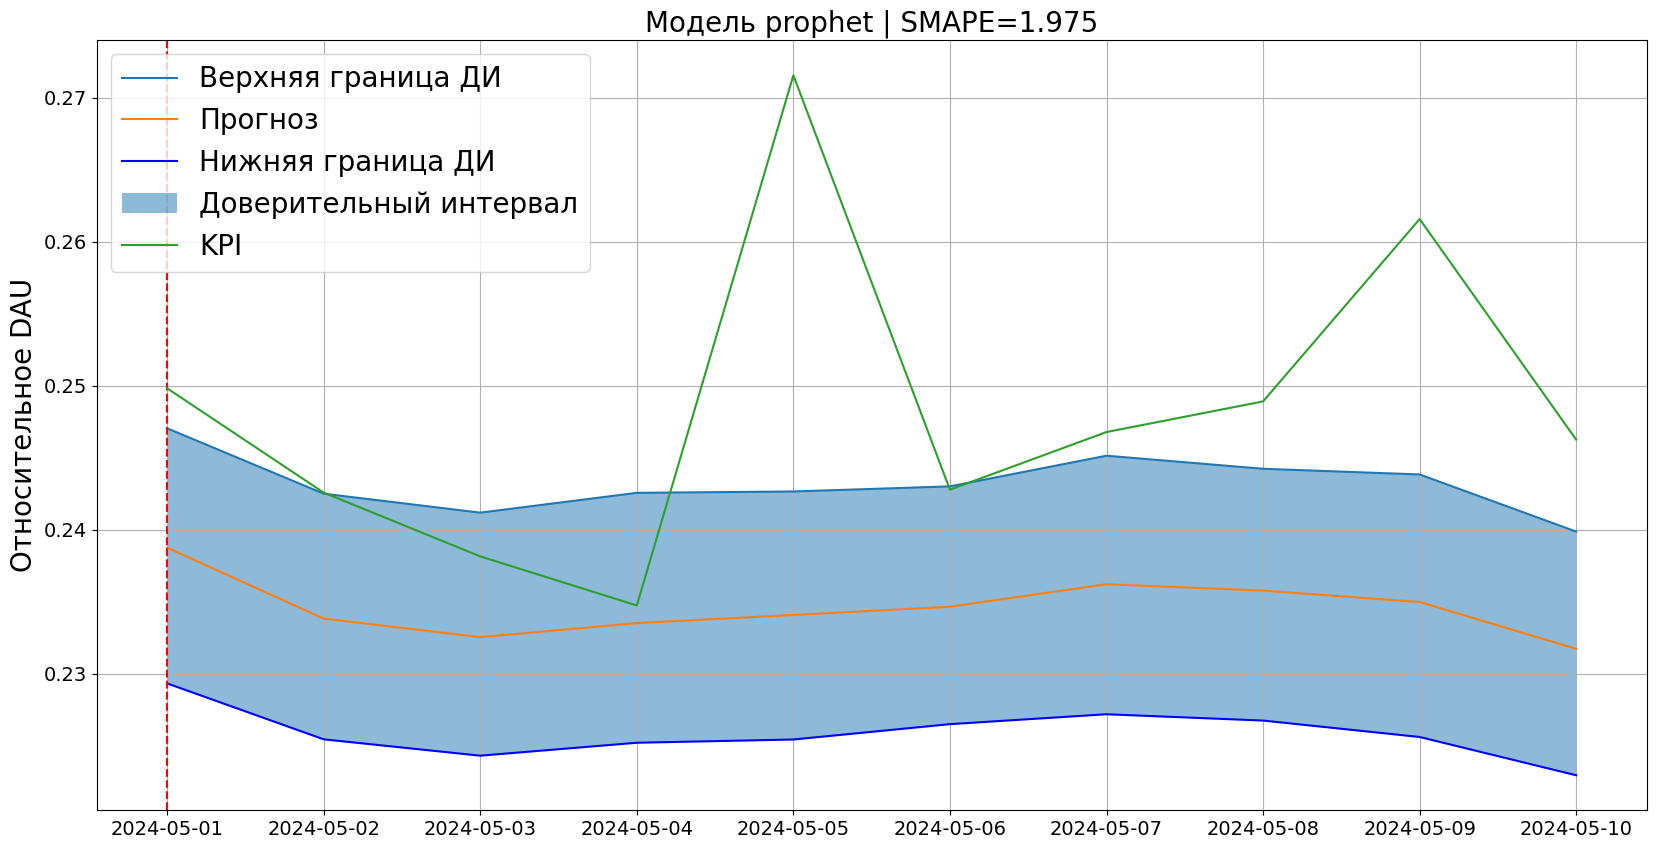

In [69]:
pred_lw = forecast['yhat_lower'].iloc[-horizon:].values
pred = forecast['yhat'].iloc[-horizon:].values
pred_up = forecast['yhat_upper'].iloc[-horizon:].values
date = pd.to_datetime(forecast.ds.iloc[-horizon:].values)
plt.figure(figsize=(20,10))
plt.plot(date, pred_up, label = 'Верхняя граница ДИ')
plt.plot(date,pred , label = 'Прогноз')
plt.plot(date, pred_lw, color='blue',label = 'Нижняя граница ДИ')
plt.fill_between(date, pred_lw,pred_up, alpha=0.5,
                label = 'Доверительный интервал')
plt.axvline(x=date[0], color='red', linestyle='--')
plt.plot(pd.to_datetime(data['ds'].iloc[-horizon:]), data['y'].iloc[-horizon:],label = 'KPI')
plt.ylabel('Относительное DAU',fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title(f'Модель prophet | SMAPE={round(SMAPE(forecast.yhat[horizon:], data.y[horizon:]),3)}',fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)

In [70]:
date_start = '2024-03-18'
date_end = '2024-04-30'
forecast.index = df.index
kpi_wo_ad = (df[kpi] - forecast['media_total_ots']*coefficients[0][1])*df['dau_runet_35_plus']*1_000_000
kpi_wo_ad.index = pd.to_datetime(kpi_wo_ad.index)
kpi_wo_ad = kpi_wo_ad[(kpi_wo_ad.index >= date_start)&(kpi_wo_ad.index <=date_end)]
kpi_with_add = df.loc[date_start:date_end, kpi]*df.loc[date_start:date_end, 'dau_runet_35_plus']*1_000_000
imp = forecast.loc[date_start:date_end,'media_total_ots']*coefficients[0][0]*df.loc[date_start:date_end, 'dau_runet_35_plus']*1_000_000
d = pd.DataFrame(columns = ['budget','date_start','date_end','impact','kpi','impact_%','add_impact_%','CPA'],index=['media_total_ots_multi'])
d['budget'] = media_budget.iloc[-1]
d['date_start'] = date_start
d['date_end'] = date_end
d['impact'] = np.mean(imp)
d['kpi'] = np.mean(kpi_with_add)
d['impact_%'] = d['impact'] / d['kpi'] * 100
d['add_impact_%'] = d['impact'] / np.mean(kpi_wo_ad)
d['CPA'] = media_budget['budget'][-1]/((pd.to_datetime(date_end) - pd.to_datetime(date_start)).days+1)/ d['impact']             
print('Сценарий без РК:', round(np.mean(kpi_wo_ad), 4))
imp_per = round(d['impact_%'][0],5)
d.T

Сценарий без РК: 15612519.4124


media_total_ots_multi
budget                         NaN
date_start              2024-03-18
date_end                2024-04-30
impact                    -175.060
kpi                   15612911.364
impact_%                    -0.001
add_impact_%                -0.000
CPA                      -2159.527

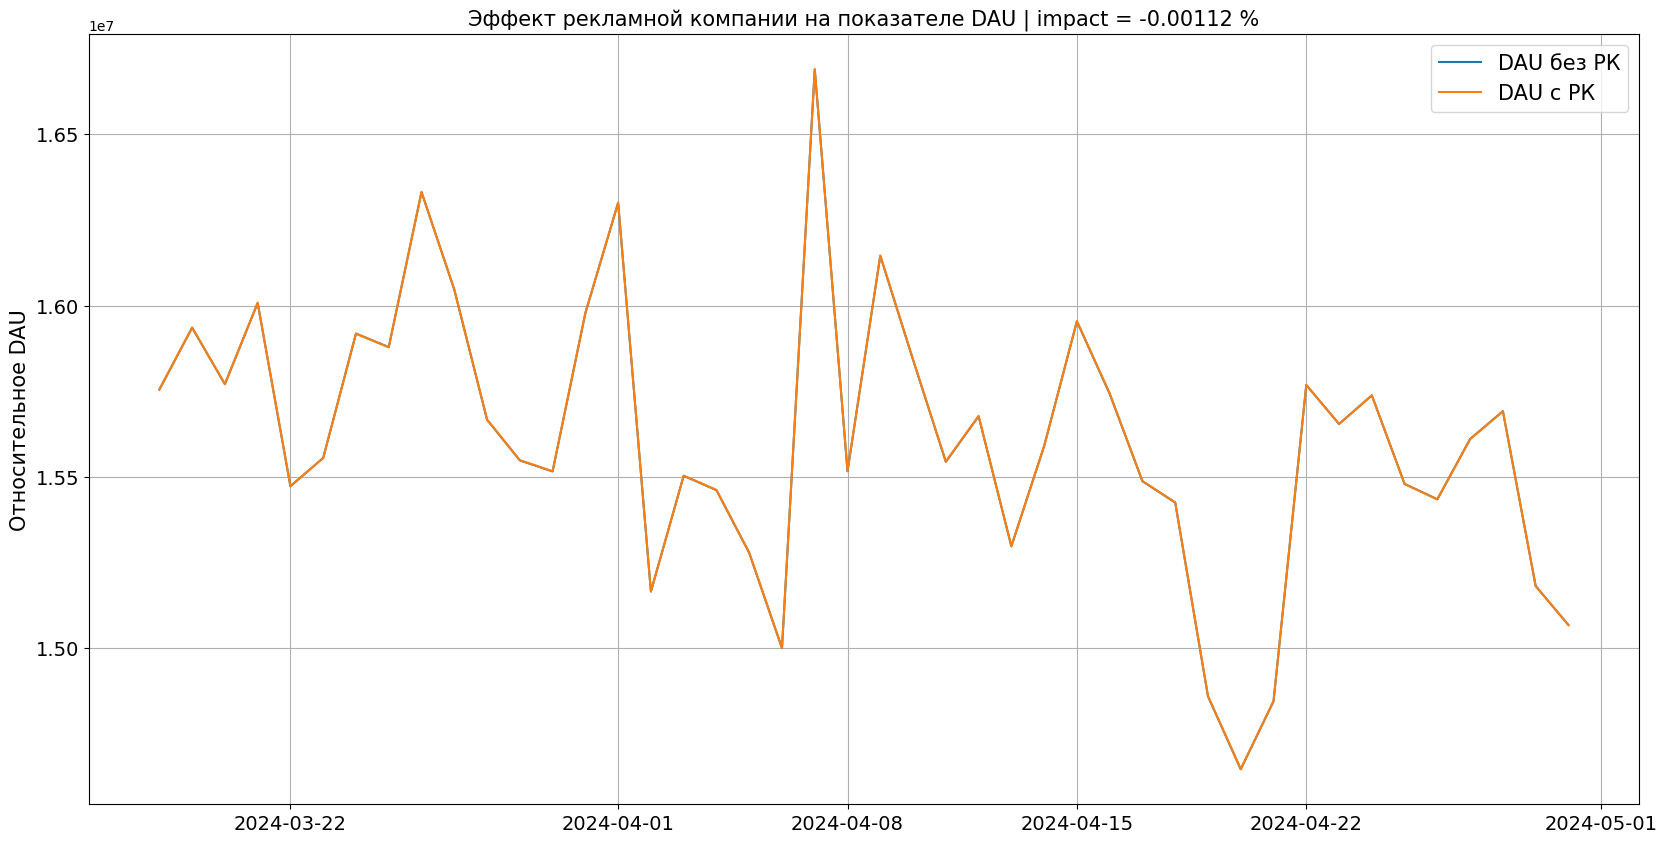

In [71]:
kpi_with_add.index = pd.to_datetime(kpi_with_add.index)
plt.figure(figsize=(20,10))
plt.plot(kpi_wo_ad)
plt.plot(kpi_with_add)
plt.grid(True)
plt.title(f'Эффект рекламной компании на показателе DAU | impact = {imp_per} %',fontsize=15)
plt.ylabel('Относительное DAU',fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(['DAU без РК','DAU с РК'],fontsize=15)
plt.show()

### 3. CatBoost

In [72]:
model_factors = non_media_final_factors + ['media_total_ots']
X = df[model_factors].copy()

X_train = X.head(-horizon)
y_train = y.head(-horizon)

X_test = X.tail(horizon)
y_test = y.tail(horizon)

In [73]:
# Обучение модели CatBoost
model = CatBoostRegressor(iterations=10000, depth=12, learning_rate=0.01)
model.fit(X_train, y_train,verbose=False)
catbost_pred = model.predict(X_test)

In [74]:
catbost_pred = pd.Series(catbost_pred,index = y_test.index)

In [75]:
rmse_catboost = RMSE(catbost_pred,y_test)
smape_catboost = SMAPE(catbost_pred,y_test)
wape_catboost = WAPE(catbost_pred,y_test)
print(f"CatBoost:\nWAPE: {round(wape_catboost,4)}\nSMAPE: {round(smape_catboost,4)}\nRMSE: {round(rmse_catboost,4)}")
res['CatBoost'] = round(wape_catboost,3),round(smape_catboost,3),round(rmse_catboost,3)

CatBoost:
WAPE: 2.8522
SMAPE: 2.824
RMSE: 0.0099


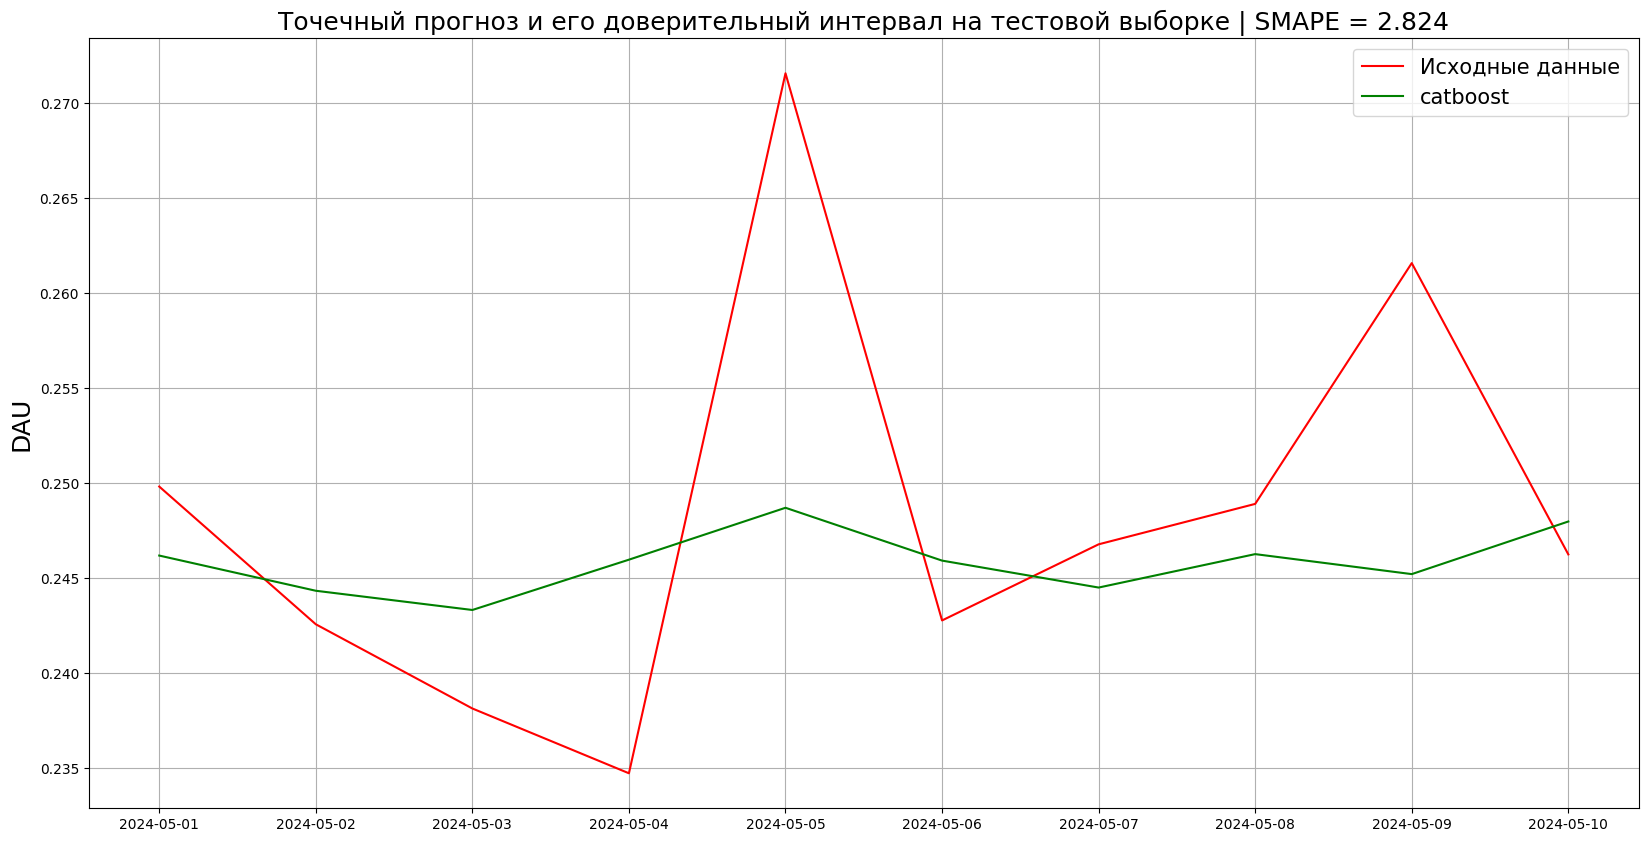

In [76]:
plt.figure(figsize=(20, 10))

# График исходных данных
plt.plot(y_test.index, y_test, label='Исходные данные', color='red')

# График предсказанных значений
plt.plot(y_test.index, catbost_pred, color='green', label='catboost')

# # График доверительного интервала
# plt.fill_between(y_test.index, forecast_intervals[:, 0], forecast_intervals[:, 1], color='green', alpha=0.5, label='Доверительный интервал')

plt.ylabel('DAU', fontsize=18)
plt.title(f'Точечный прогноз и его доверительный интервал на тестовой выборке | SMAPE = {round(SMAPE(catbost_pred,y_test),3)}', fontsize=18)
plt.legend(fontsize=15)
plt.grid(True)

# plt.gca().xaxis.set_major_locator(WeekdayLocator(byweekday=mdates.MONDAY))
# plt.gcf().autofmt_xdate()


plt.show()

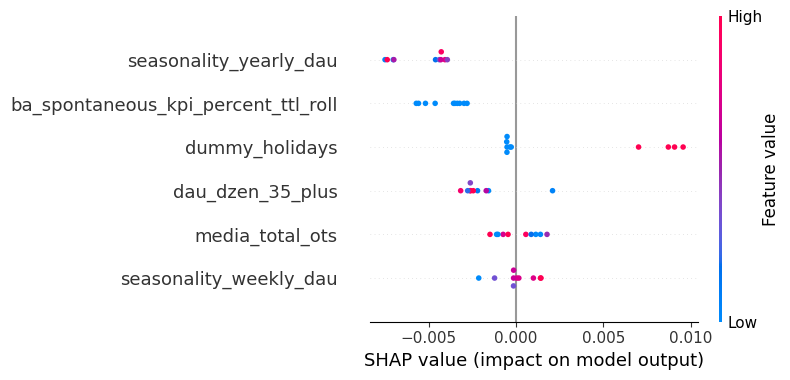

In [77]:
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_test)

# Визуализация SHAP значений
shap.summary_plot(shap_values, X_test)

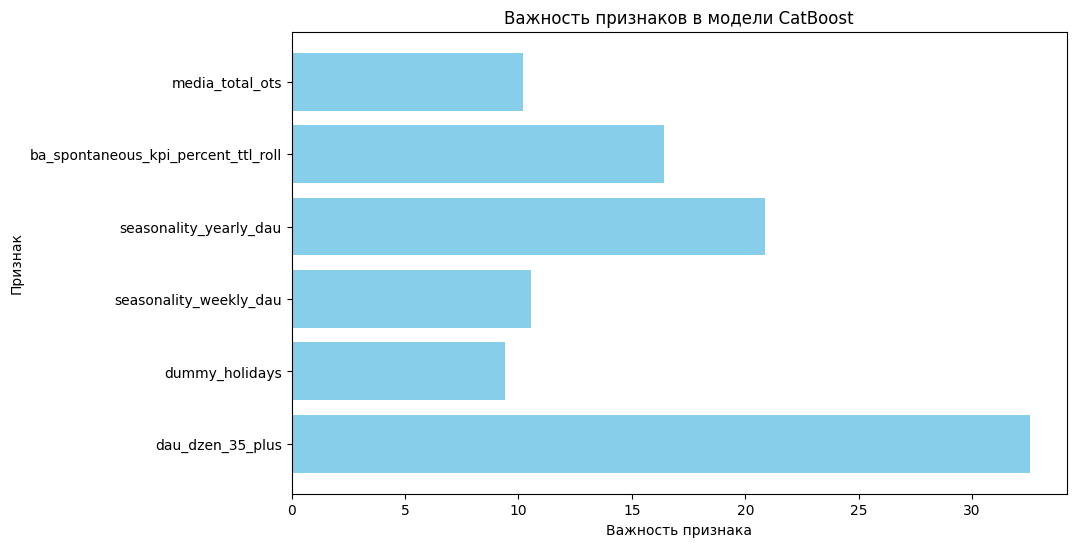

In [78]:
# Получение важности признаков
feature_importance = model.get_feature_importance(data=catboost.Pool(X_train, label=y_train))

# Создание графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, feature_importance, color='skyblue')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoost')
plt.show()

### **GAM**

- splines_order (splord): Этот гиперпараметр определяет порядок сплайнов, которые используются для аппроксимации нелинейных зависимостей в данных. Чем выше порядок сплайнов, тем более сложные зависимости могут быть захвачены моделью. Обычно этот гиперпараметр выбирается экспериментальным путем, начиная с низкого значения и постепенно увеличивая его для достижения оптимального результата.

- n_splines (nspl): Этот гиперпараметр определяет количество сплайнов, которые будут использоваться в модели. Большее количество сплайнов позволяет более гибко аппроксимировать сложные зависимости, но также может привести к переобучению. Настраивайте это значение, чтобы достигнуть баланса между гибкостью модели и её обобщающей способностью.

- lambda (lam): Этот гиперпараметр контролирует регуляризацию модели. Большое значение lambda приведет к более сильной регуляризации, что поможет предотвратить переобучение, но может уменьшить точность модели. Настройка этого гиперпараметра может быть выполнена с использованием методов кросс-валидации или других техник подбора гиперпараметров.

- constraint (cnst): Этот гиперпараметр определяет, следует ли применять ограничения к сплайнам в модели. Например, можно добавить ограничения монотонности или выпуклости к сплайнам для улучшения интерпретируемости модели.

- diff_order (dt): Этот гиперпараметр определяет порядок разностей, которые будут использоваться для оценки гладкости сплайнов. Выбор оптимального значения этого гиперпараметра может помочь улучшить производительность модели.


In [79]:
from pygam import LinearGAM
class Model:   
    def __init__(self, features=[], params={}):
        self.model_attributes()
        self.model_profile()
        self.set_features(features)  
        self.set_params(params)
        
        
    def set_features(self, features=[]): 
        self.features = list(features) if features else list(self.features_set)
            
        
    def set_params(self, params={}):
        self.params = dict(self.init_params)
        self.params.update(params)
    
    
    def model_attributes(self):
        self.features = None
        self.params = None
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_pred = None
    
   
    #______________________________Спецификация модели_____________________________________
    
    def model_profile(self):

        self.init_params = {
            'splord__dau_dzen_35_plus': 2,
            'nspl__dau_dzen_35_plus': 6,
            'lam__dau_dzen_35_plus': 2,  
            'cnst__dau_dzen_35_plus':'monotonic_inc',
            'dt__dau_dzen_35_plus': 'numerical',

            'splord__seasonality_yearly_dau': 2,
            'nspl__seasonality_yearly_dau': 6,
            'lam__seasonality_yearly_dau': 10,  
            'cnst__seasonality_yearly_dau':'center',
            'dt__seasonality_yearly_dau': 'quantile',

            'splord__seasonality_weekly_dau': 2,
            'nspl__seasonality_weekly_dau': 6,
            'lam__seasonality_weekly_dau': 5,  
            'cnst__seasonality_weekly_dau':'center',
            'dt__seasonality_weekly_dau': 'quantile',
     
            'splord__dummy_holidays': 1,
            'nspl__dummy_holidays': 3,
            'lam__dummy_holidays': 10,
            'cnst__dummy_holidays':'center',
            'dt__dummy_holidays': 'quantile',
     
            'splord__media_total_ots': 3,
            'nspl__media_total_ots': 4,
            'lam__media_total_ots': 10,
            'cnst__media_total_ots':'monotonic_inc',
            'dt__media_total_ots': 'quantile',

            'splord__ba_spontaneous_kpi_percent_ttl_roll': 3,
            'nspl__ba_spontaneous_kpi_percent_ttl_roll': 4,
            'lam__ba_spontaneous_kpi_percent_ttl_roll': 4,
            'cnst__ba_spontaneous_kpi_percent_ttl_roll':'monotonic_inc',
            'dt__ba_spontaneous_kpi_percent_ttl_roll': 'quantile'
         
        } 
            
        self.params_set = {
            'splord__dau_dzen_35_plus': {'start': 2, 'stop': 100, 'step': 10},
            'nspl__dau_dzen_35_plus': {'start': 1, 'stop': 100, 'step': 10},
            'lam__dau_dzen_35_plus': {'start': 0, 'stop': 100, 'step': 1.0},  
            'cnst__dau_dzen_35_plus':['monotonic_inc'],
            'dt__dau_dzen_35_plus': ['numerical'],


            'splord__seasonality_weekly_dau': {'start': 2, 'stop': 100, 'step': 10},
            'nspl__seasonality_weekly_dau': {'start': 1, 'stop': 100, 'step': 10},
            'lam__seasonality_weekly_dau': {'start': 0, 'stop': 100, 'step': 1.0},  
            'cnst__seasonality_weekly_dau':['monotonic_inc'],
            'dt__seasonality_weekly_dau': ['numerical'],

            'splord__seasonality_weekly_dau': {'start': 2, 'stop': 100, 'step': 10},
            'nspl__seasonality_weekly_dau': {'start': 1, 'stop': 100, 'step': 10},
            'lam__seasonality_weekly_dau': {'start': 0, 'stop': 100, 'step': 1.0},  
            'cnst__seasonality_weekly_dau':['monotonic_inc'],
            'dt__seasonality_weekly_dau': ['numerical'],

            'splord__dummy_holidays': {'start': 2, 'stop': 100, 'step': 10},
            'nspl__dummy_holidays': {'start': 1, 'stop': 100, 'step': 10},
            'lam__dummy_holidays': {'start': 0, 'stop': 100, 'step': 1.0},
            'cnst__dummy_holidays':['monotonic_inc'],
            'dt__dummy_holidays': ['numerical'],
     
            'splord__media_total_ots': {'start': 2, 'stop': 100, 'step': 10},
            'nspl__media_total_ots': {'start': 1, 'stop': 100, 'step': 10},
            'lam__media_total_ots': {'start': 0, 'stop': 100, 'step': 1.0},
            'cnst__media_total_ots':['monotonic_inc'],
            'dt__media_total_ots': ['numerical'],

            'splord__ba_spontaneous_kpi_percent_ttl_roll': {'start': 2, 'stop': 100, 'step': 10},
            'nspl__ba_spontaneous_kpi_percent_ttl_roll': {'start': 1, 'stop': 100, 'step': 10},
            'lam__ba_spontaneous_kpi_percent_ttl_roll': {'start': 0, 'stop': 100, 'step': 1.0},
            'cnst__ba_spontaneous_kpi_percent_ttl_roll':['monotonic_inc'],
            'dt__ba_spontaneous_kpi_percent_ttl_roll': ['numerical']

        }
            
        self.features_set = ['dau_dzen_35_plus', 'seasonality_yearly_dau','seasonality_weekly_dau','dummy_holidays', 'media_total_ots','ba_spontaneous_kpi_percent_ttl_roll']
        self.date_col = 'dt'

        self.target = kpi            
            
    def fit(self, x_train, y_train):
         
        spl_ord = []
        n_spl = []
        lams = []
        constraints = []
        dtype = []
        for i, feature in enumerate(self.features):
            spl_ord.append(self.params['splord__' + feature])
            n_spl.append(self.params['nspl__' + feature])
            lams.append(self.params['lam__' + feature])
            constraints.append(self.params['cnst__' + feature])
            dtype.append(self.params['dt__' + feature])
            
        params_new = {
                    'spline_order': spl_ord,
                    'n_splines': n_spl,
                    'lam': lams,
                    'constraints': constraints,
                    'dtype': dtype}

        self.estimator = LinearGAM(fit_intercept = True, penalties = 'auto', fit_linear = False)
        self.estimator.set_params(**params_new)
        self.estimator.fit(x_train[self.features], y_train)
        self.x_train = x_train[self.features]
        self.y_train = y_train

    def predict(self, x_test):
        self.x_test = x_test[self.features]
        self.y_pred = self.estimator.predict(self.x_test)
        return self.y_pred

In [80]:
model = Model()
model.features, model.target

(['dau_dzen_35_plus',
  'seasonality_yearly_dau',
  'seasonality_weekly_dau',
  'dummy_holidays',
  'media_total_ots',
  'ba_spontaneous_kpi_percent_ttl_roll'],
 'dau_ok_35_plus_relative')

In [81]:
X = df[model.features].copy()

X_train = X.head(-horizon)
y_train = df[model.target].head(-horizon)

X_test = X.tail(horizon)
y_test = df[model.target].tail(horizon)

In [82]:
model.fit(X_train,y_train)
model.estimator.summary()
y_pred = model.predict(X_test)
rmse_gam = RMSE(y_pred,y_test)
smape_gam = SMAPE(y_pred,y_test)
wape_gam = WAPE(y_pred,y_test)
print(f"CatBoost:\nWAPE: {round(wape_gam,4)}\nSMAPE: {round(smape_gam,4)}\nRMSE: {round(rmse_gam,4)}")
res['LinearGam'] = round(wape_gam,3),round(smape_gam,3),round(rmse_gam,3)

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     52.1101
Link Function:                     IdentityLink Log Likelihood:                              -6382257.1198
Number of Samples:                          590 AIC:                                         12764620.4597
                                                AICc:                                         12764631.185
                                                GCV:                                                   0.0
                                                Scale:                                                 0.0
                                                Pseudo R-Squared:                                   0.7816
Feature Function                  Lam

In [83]:
plot_decomposition_gam(y_train,
                       X_train[model.features],
                       model,
                       kpi_name=kpi)

In [84]:
resid = model.estimator.deviance_residuals(X_train[model.features],y_train)
s_0 = pd.Series(model.estimator.partial_dependence(term=0,X=X_train[model.features]),index=y_train.index)
s_1 = pd.Series(model.estimator.partial_dependence(term=1,X=X_train[model.features]),index=y_train.index)
s_2 = pd.Series(model.estimator.partial_dependence(term=2,X=X_train[model.features]),index=y_train.index)
s_3 = pd.Series(model.estimator.partial_dependence(term=3,X=X_train[model.features]),index=y_train.index)
s_4 = pd.Series(model.estimator.partial_dependence(term=4,X=X_train[model.features]),index=y_train.index)
s_5 = pd.Series(model.estimator.partial_dependence(term=5,X=X_train[model.features]),index=y_train.index)
intercept=  pd.Series(model.estimator.coef_[-1],index=y_train.index)
yped = s_0 + s_1 + s_2 + s_3 + s_4+ s_5 + intercept

y_fitted = pd.Series(model.estimator.predict(X_train[model.features]),index=y_train.index)

### **Вклад в медиа**

In [85]:
date_start = media_budget.date_start[0]
date_end = media_budget.date_end[0]
imp_df=pd.DataFrame()

y_train.index  = pd.to_datetime(y_train.index)
s_4.index = pd.to_datetime(s_4.index)
y_tr = y_train[(y_train.index >= date_start)&(y_train.index <= date_end)]
s_4_tr = s_4[(s_4.index >= date_start)&(s_4.index <= date_end)]
y_tr.index = s_4_tr.index
runet = df.loc[date_start:date_end, 'dau_runet_35_plus']*1_000_000
runet.index = y_tr.index

imp_df['Kpi_wo_ad'] = (y_tr - s_4_tr)*runet

avg_over_period = True
def agg_func(x):
    if avg_over_period:
        return(np.mean(x, axis=0))
    else:
        return(np.sum(x, axis=0))
    
df_flow = media_budget.copy()
df_flow['date_start'] = pd.to_datetime(df_flow['date_start'][0])
df_flow['date_end'] = pd.to_datetime(df_flow['date_end'][0])

df_flow['impact'] = agg_func(s_4_tr*runet)
df_flow['kpi'] = agg_func(y_tr*runet)

df_flow['impact_%'] = df_flow['impact'] / df_flow['kpi'] * 100
df_flow['add_impact_%'] = df_flow['impact'] /\
                                   agg_func(imp_df['Kpi_wo_ad']) * 100
df_flow['CPA'] = (df_flow['budget']/\
                           np.where(avg_over_period, (pd.to_datetime(date_end) - pd.to_datetime(date_start)).days+1, 1)) /\
                           df_flow['impact']             
print('Сценарий без РК:', round(agg_func(imp_df['Kpi_wo_ad']), 4))
imp = pd.DataFrame(df_flow.iloc[-1,:])
imp

Сценарий без РК: 15096924.4014


radio_ots
budget               16634085.000
date_start    2024-03-18 00:00:00
date_end      2024-04-30 00:00:00
impact                 515986.962
kpi                  15612911.364
impact_%                    3.305
add_impact_%                3.418
CPA                         0.733

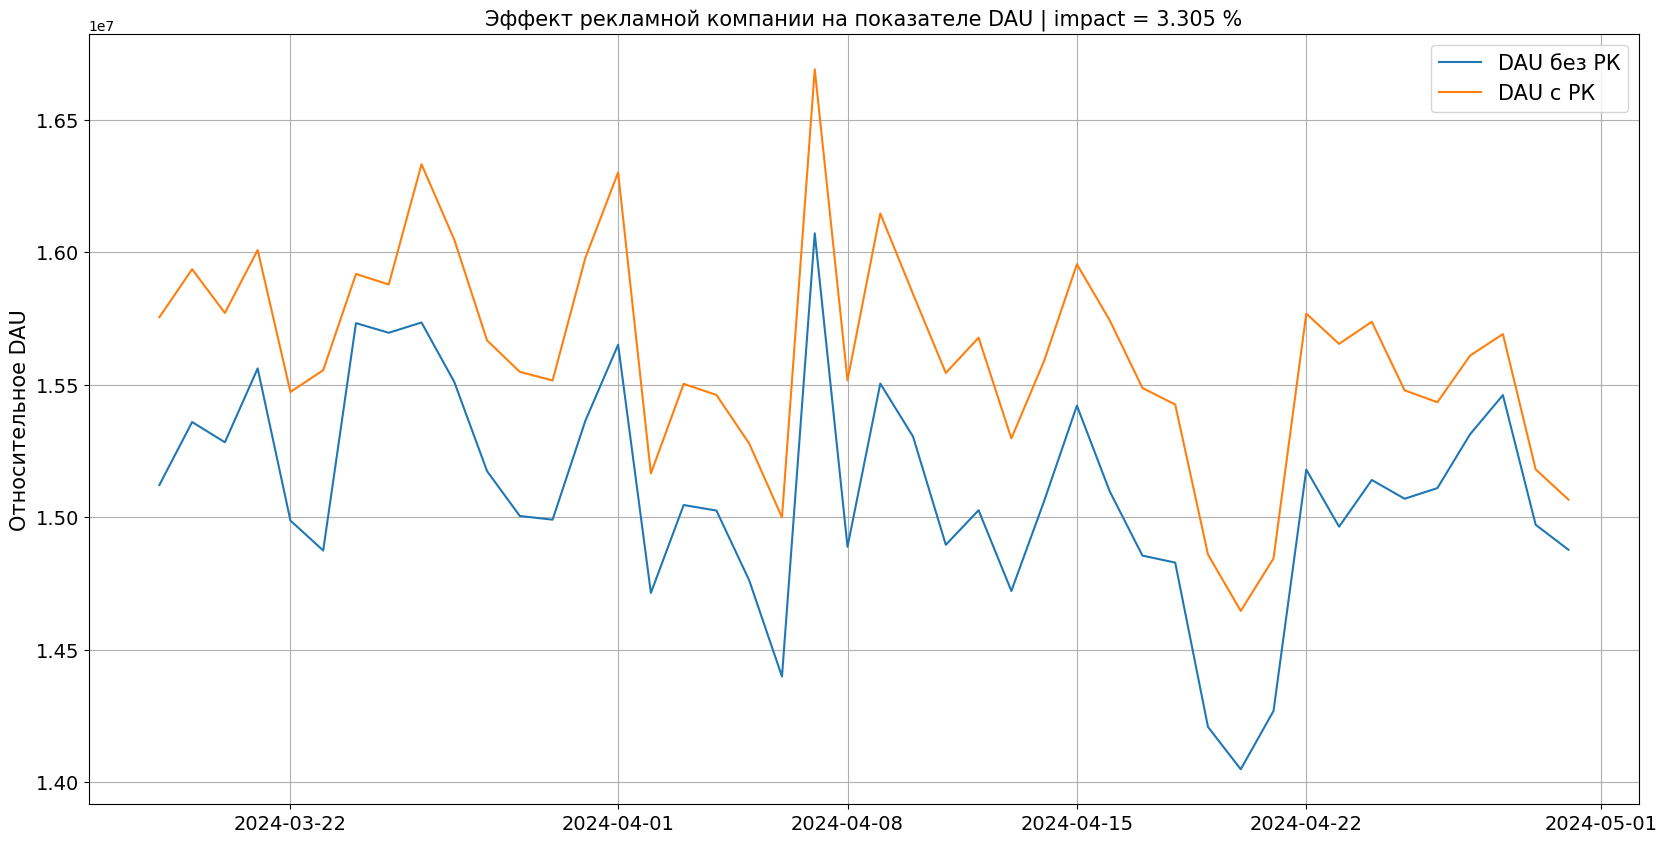

In [86]:
imp_per=imp.loc['impact_%',:]
plt.figure(figsize=(20,10))
plt.plot(imp_df['Kpi_wo_ad'])
plt.plot(y_tr*runet)
plt.grid(True)
plt.title(f'Эффект рекламной компании на показателе DAU | impact = {round(imp_per[0],3)} %',fontsize=15)
plt.ylabel('Относительное DAU',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['DAU без РК','DAU с РК'],fontsize=15)
plt.show()

In [87]:
res

additive_2mnk_linear_reg_1  additive_2mnk_linear_reg_2  \
WAPE                        2.113                       2.209   
SMAPE                       2.083                       2.178   
RMSE                        0.006                       0.007   

       multi_linear_reg  Prophet  CatBoost  LinearGam  
WAPE              2.186    1.983     2.852      2.761  
SMAPE             2.155    1.975     2.824      2.757  
RMSE              0.007    0.007     0.010      0.008

### **Ridge**

**Подберем оптимальный регуляризационный член (alpha) для Ridge-регрессии**

Best alpha = 0.0000


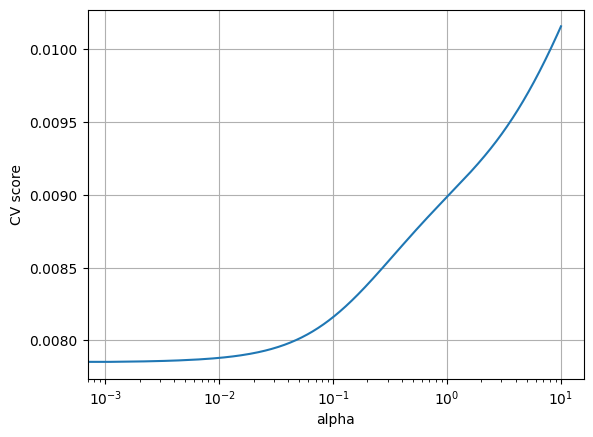

In [88]:
from sklearn.model_selection import GridSearchCV

alphas = np.linspace(-1, 10, 10000)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")
plt.grid(True)

In [89]:
# ridge-регрессия 
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
y_model = model.predict(X_test)

In [90]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

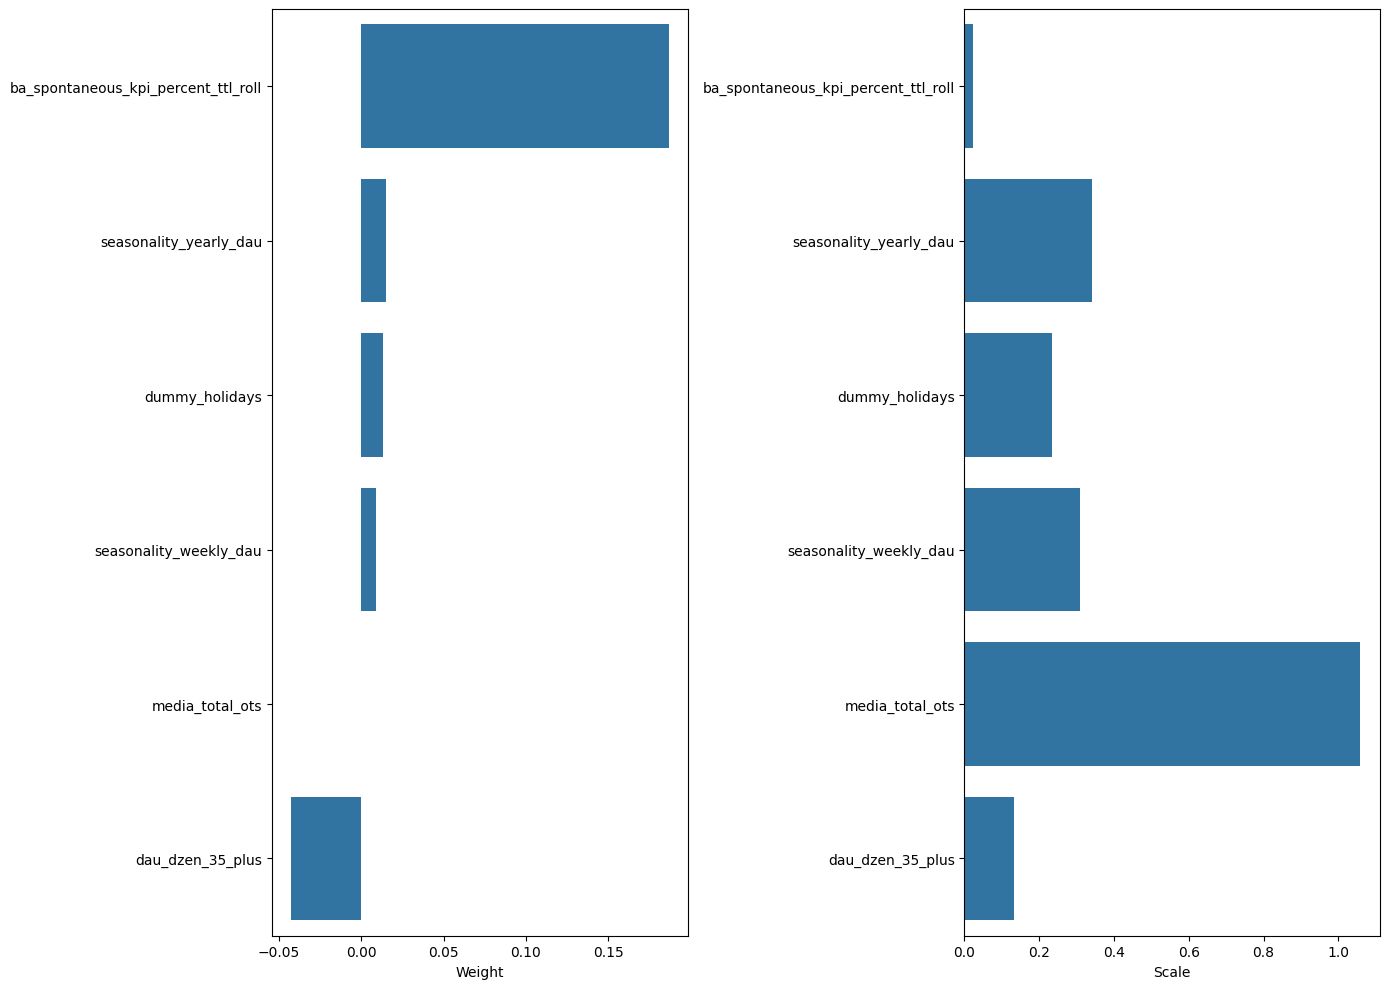

In [91]:
scales = pd.Series(data=X.std(axis=0), index=X.columns.values)
show_weights(X.columns.values, model.coef_, scales)

In [92]:
# Оценка качества модели
rmse_ridge = RMSE(y_test, y_model)
smape_ridge = SMAPE(y_test, y_model)
wape_ridge = WAPE(y_test, y_model)
print(f"Ridge-регрессия:\nWAPE: {round(wape_ridge,4)}\nMAPE: {round(smape_ridge,4)}\nRMSE: {round(rmse_ridge,4)}")
res['Ridge'] = round(wape_ridge,3), round(smape_ridge,3), round(rmse_ridge,3)

Ridge-регрессия:
WAPE: 2.1621
MAPE: 2.1169
RMSE: 0.0065


### SARIMAX

In [93]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import warnings

# Преобразование Бокса-Кокса
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [94]:
df.index = pd.to_datetime(df.index)

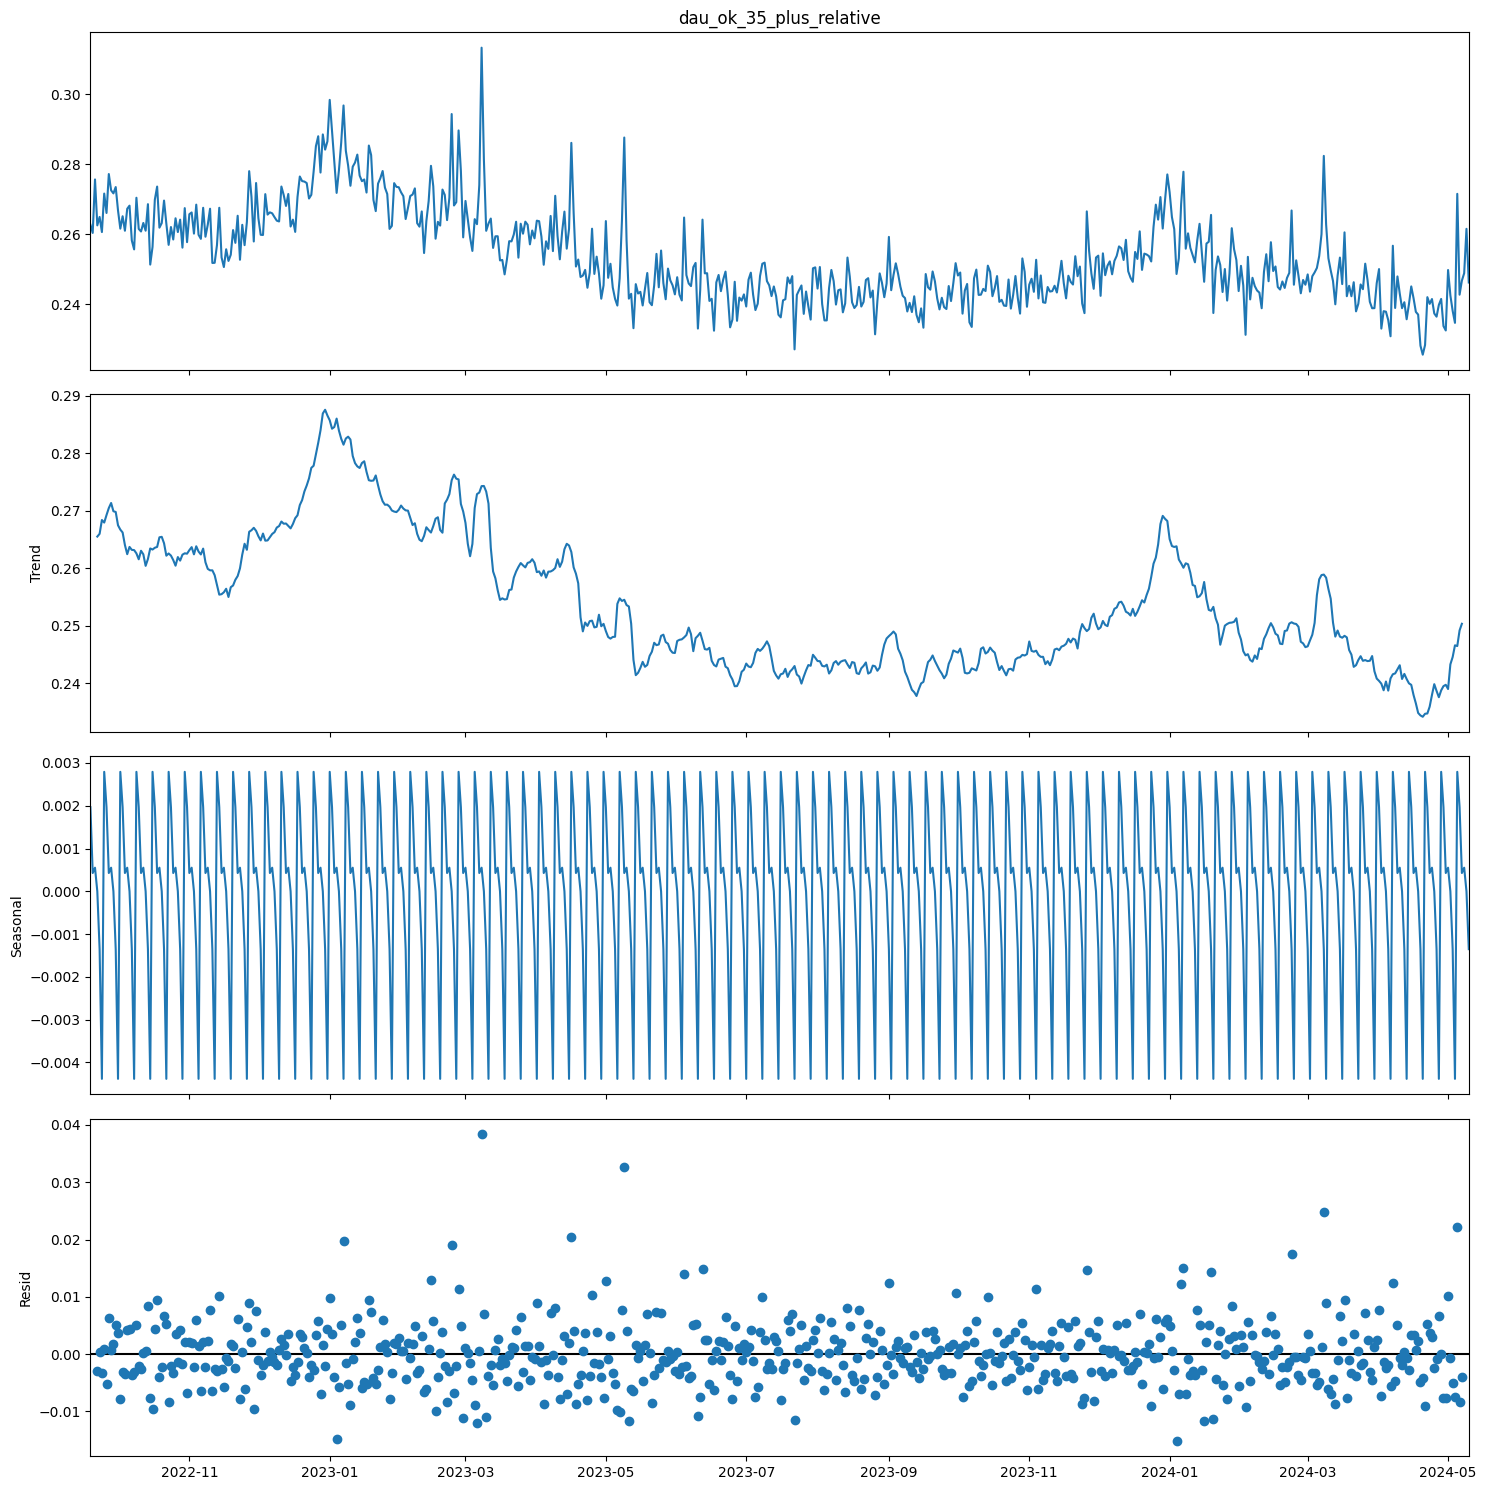

Критерий Дики-Фуллера: p=0.136391


In [95]:
# Вывод графика разложения
plt.rcParams.update({'figure.figsize': (15,15)})
sm.tsa.seasonal_decompose(df[kpi], model='additive').plot()
plt.show()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df[kpi])[1])

Оптимальный параметр преобразования Бокса-Кокса: -4.767565
Критерий Дики-Фуллера: p=0.146898


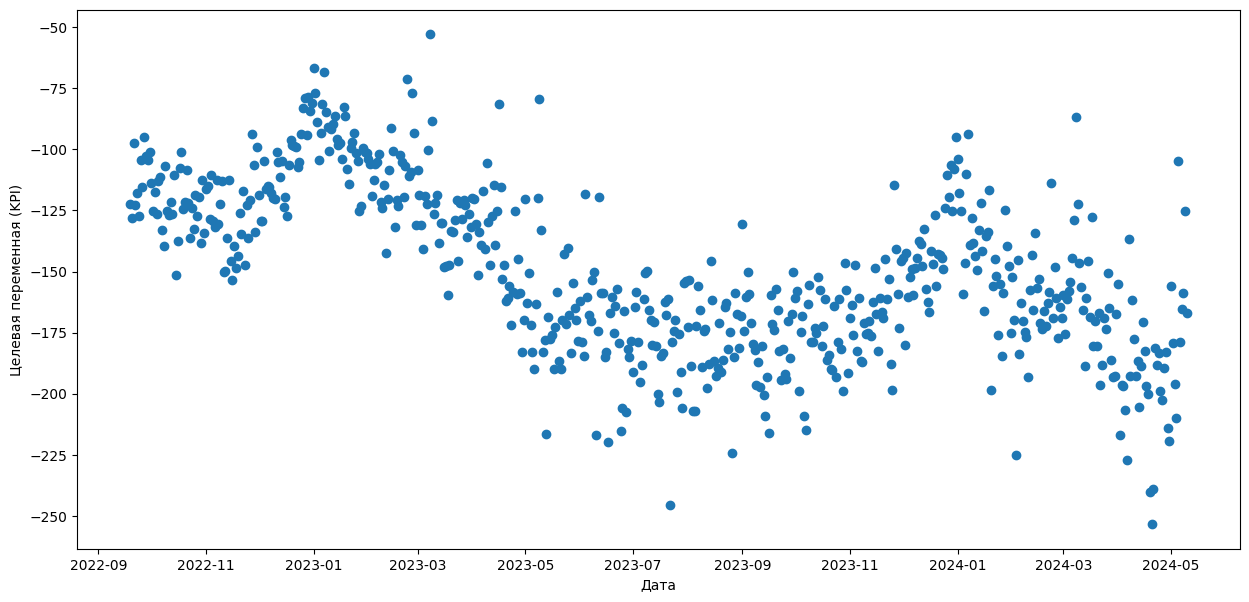

In [96]:
smooth_kpi, lmbda = stats.boxcox(df[kpi])
plt.figure(figsize=(15,7))
plt.scatter(df.index, smooth_kpi)
plt.ylabel(u'Целевая переменная (KPI)')
plt.xlabel(u'Дата')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(smooth_kpi)[1])

**Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:**

Критерий Дики-Фуллера: p=0.000000


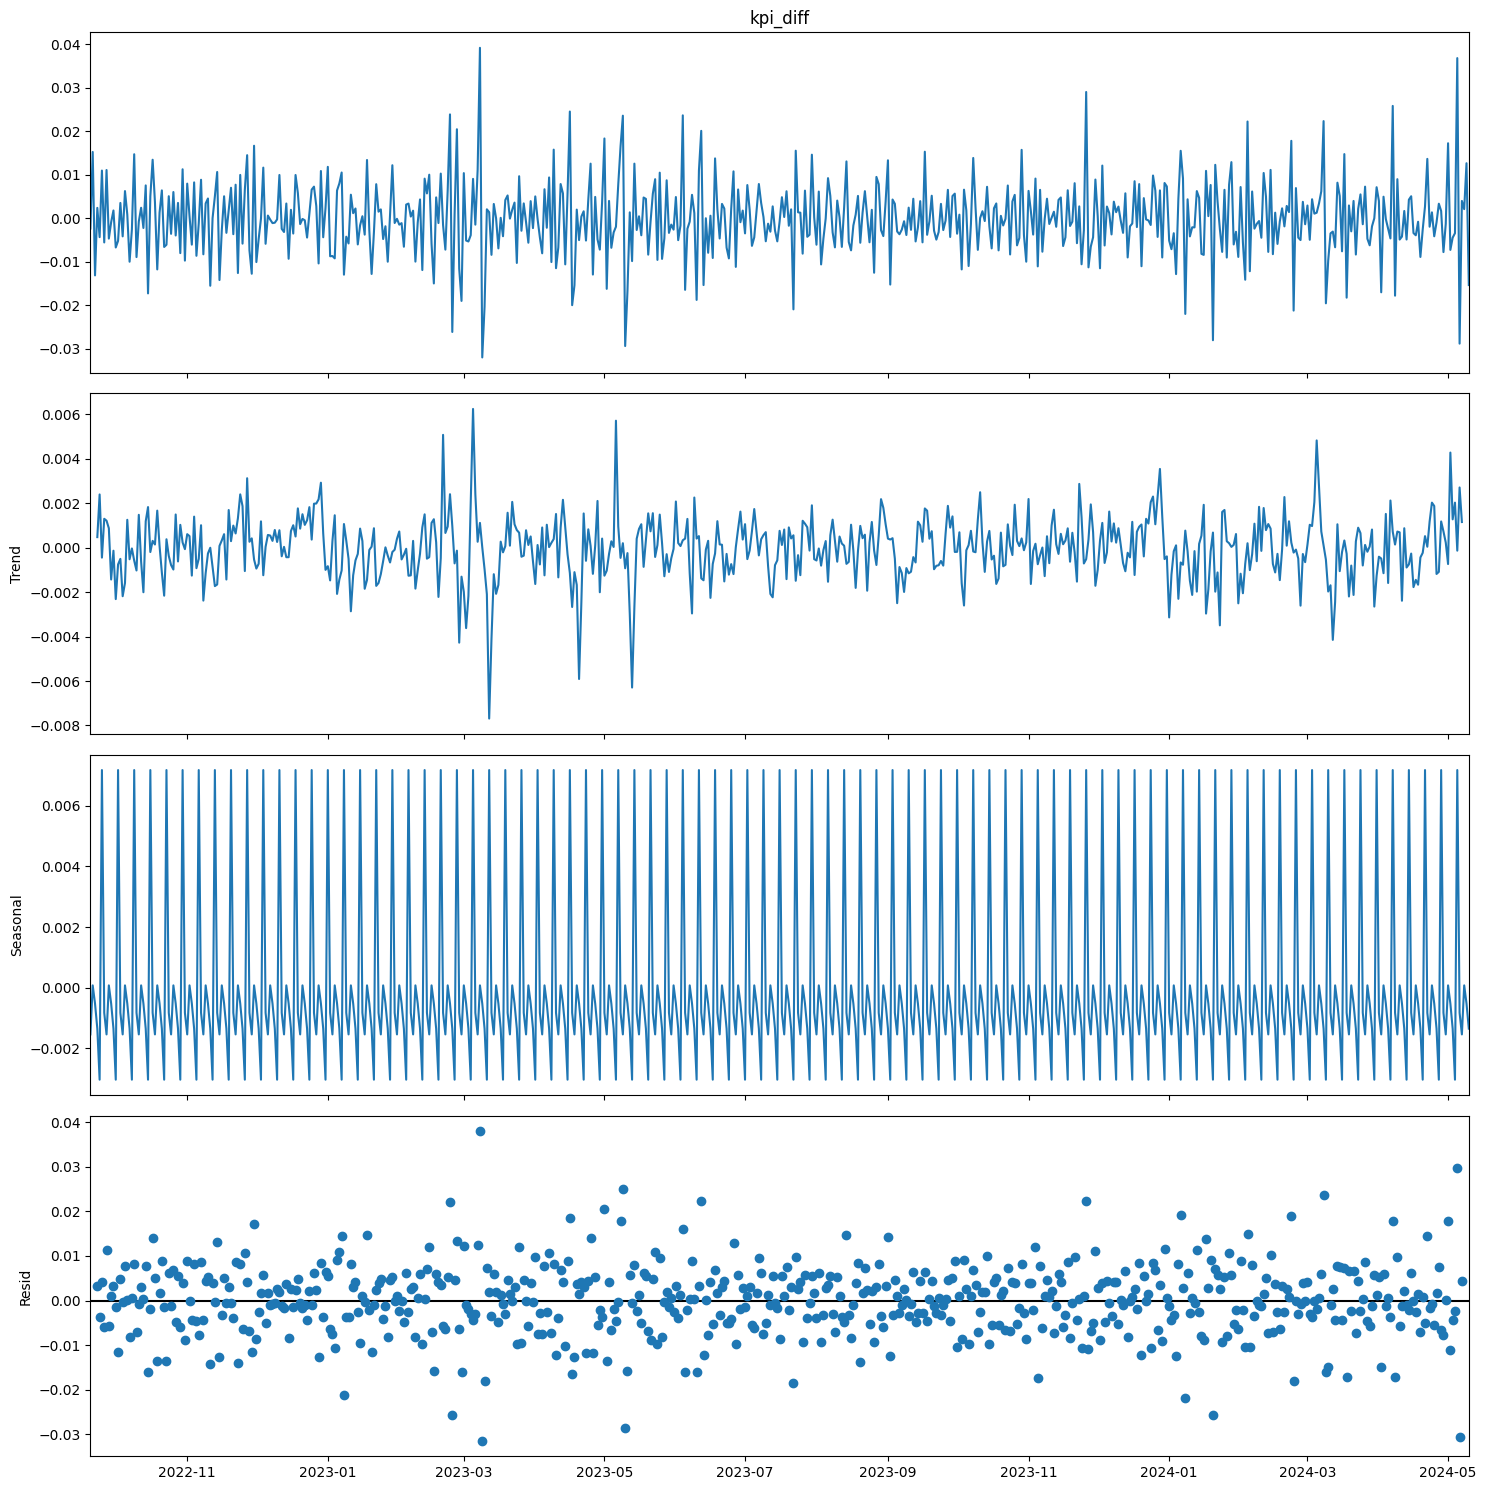

In [97]:
df['kpi_diff'] = df[kpi] - df[kpi].shift(1)
plt.rcParams.update({'figure.figsize': (15,15)})
sm.tsa.seasonal_decompose(df.kpi_diff[1:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.kpi_diff[1:])[1])

**Подбор модели**

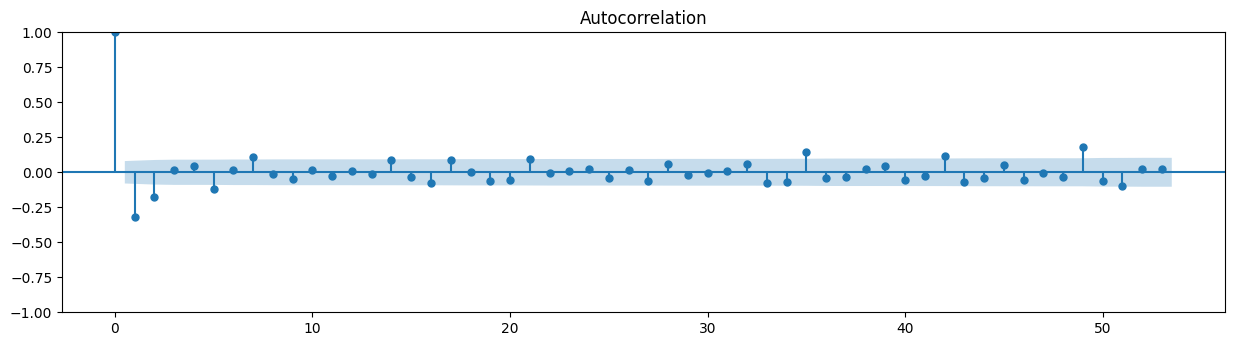

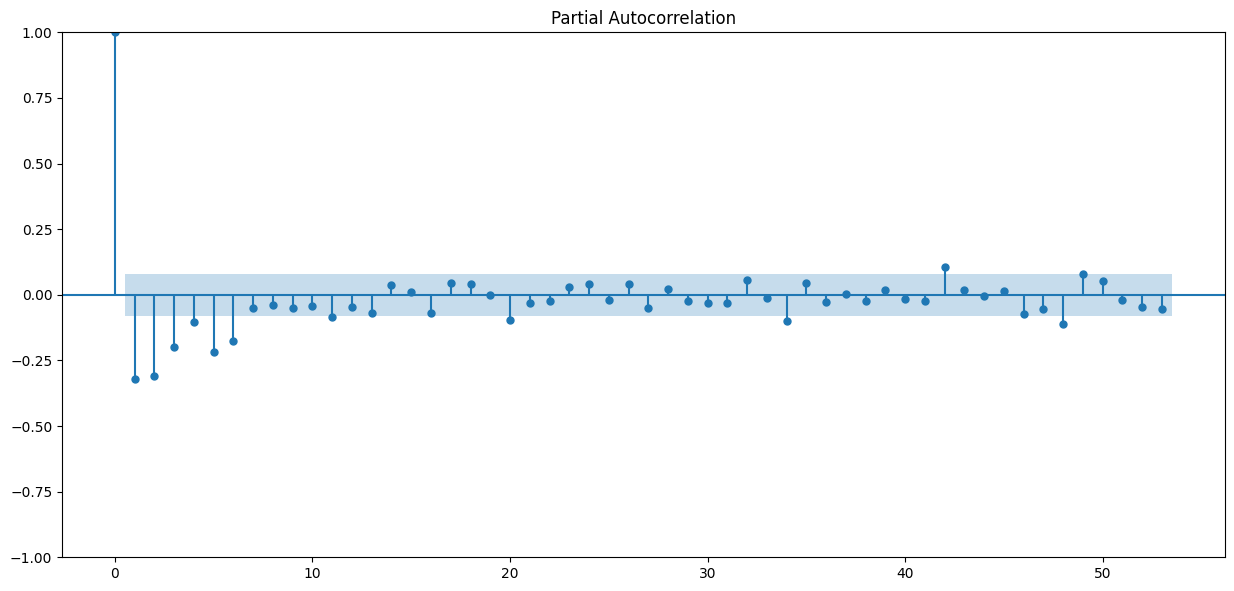

In [98]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.kpi_diff[1:].values.squeeze(), lags=53, ax=ax)
plt.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.kpi_diff[1:].values.squeeze(), lags=53, ax=ax)
plt.show()

**Посмотрим на сезонные разности**

Критерий Дики-Фуллера: p=0.000001


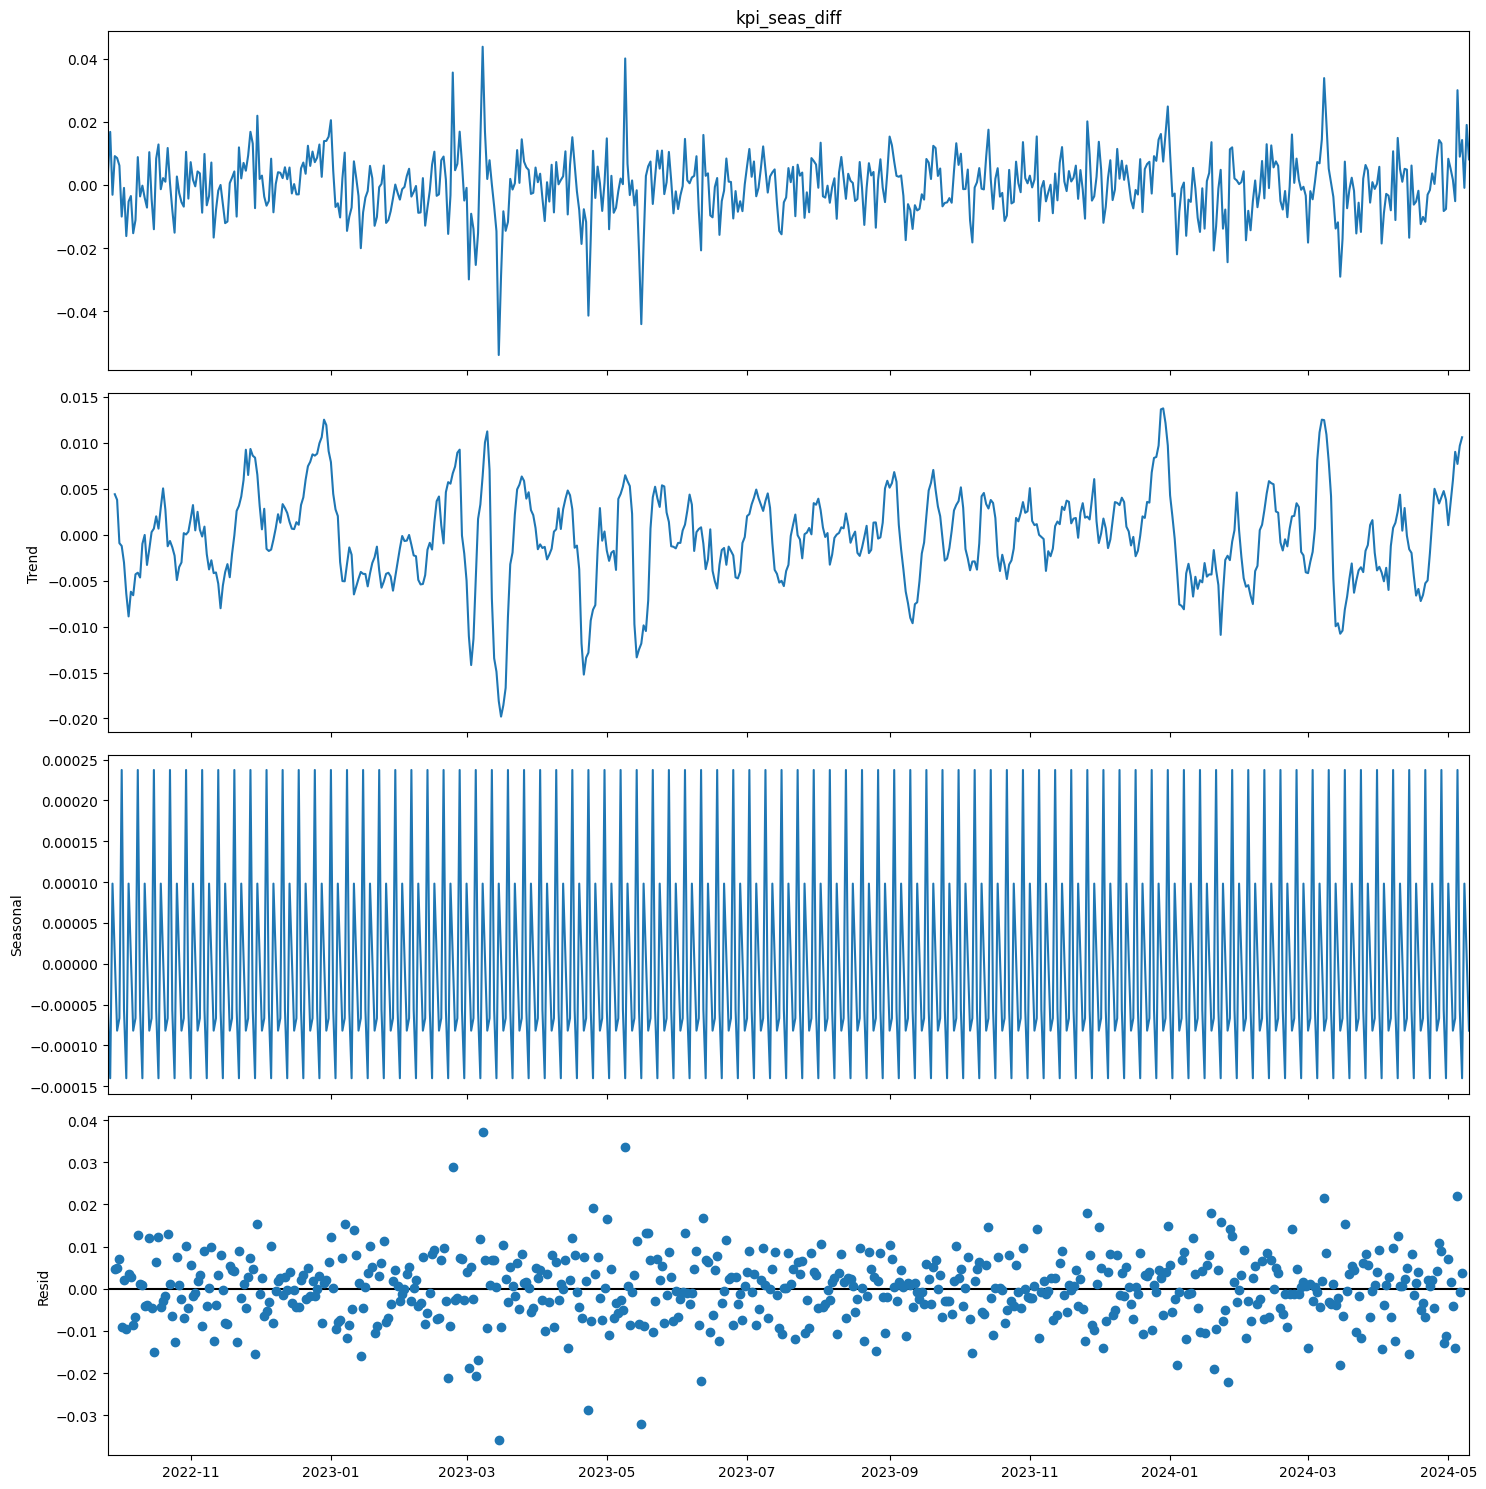

In [99]:
season=7
df['kpi_seas_diff'] = df[kpi] - df[kpi].shift(season)
plt.rcParams.update({'figure.figsize': (15,15)})
sm.tsa.seasonal_decompose(df.kpi_seas_diff[season:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.kpi_seas_diff[season:])[1])

**Зададим сетку параметров**

In [100]:
ps = range(0, 4)
d=1
qs = range(0, 4)
Ps = range(0, 3)
D=1
Qs = range(0, 3)

In [101]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [102]:
non_media_final_factors

['dau_dzen_35_plus',
 'dummy_holidays',
 'seasonality_weekly_dau',
 'seasonality_yearly_dau',
 'ba_spontaneous_kpi_percent_ttl_roll']

In [103]:
sarimax_features = ['dau_dzen_35_plus',
 'dummy_holidays',
 'seasonality_yearly_dau']

X = df[sarimax_features].copy()

X_train = X.head(-horizon)
y_train = y.head(-horizon)

X_test = X.tail(horizon)
y_test = y.tail(horizon)

In [104]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
# экспериментальным путем нашел факторы, которые привносят отрицательный (или незначительный)
# вклад в минимизацию дисперсии остатков и лишь усложняют модель
# горизонт прогнозирования
horizon=10
# Сезонность, которую учитываем моделью
season = 7
# Обучающая выборка
X_train = X_train.reindex(y_train.index)

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не сможет обучиться
    try:
        model=sm.tsa.statespace.SARIMAX(endog=y_train, exog=sm.add_constant(X_train), order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], season)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 25min 53s, sys: 19min 59s, total: 45min 52s
Wall time: 6min 2s


In [105]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
46  (1, 1, 0, 1) -4225.350
53  (1, 1, 2, 2) -4218.196
47  (1, 1, 0, 2) -4217.886
23  (0, 2, 1, 2) -4217.042
19  (0, 2, 0, 1) -4208.680


In [106]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:           dau_ok_35_plus_relative   No. Observations:                  590
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood                2120.675
Date:                           Mon, 10 Jun 2024   AIC                          -4225.350
Time:                                   15:02:02   BIC                          -4190.419
Sample:                               09-19-2022   HQIC                         -4211.734
                                    - 04-30-2024                                         
Covariance Type:                             opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -2.864e-10   6.48e-13   -442.163      0.000   -2.88e-10   -2.85e-10
dau_dze

In [107]:
# Прогнозирование значений
season=7
# Обучим модель SARIMAX
X = df[sarimax_features].copy()

X_train = X.head(-horizon)
y_train = y.head(-horizon)

X_test = X.tail(horizon)
y_test = y.tail(horizon)
X_train = X_train.reindex(y_train.index)
model=sm.tsa.statespace.SARIMAX(endog=y_train, exog=sm.add_constant(X_train), 
                                        order=(1,d,1), 
                                        seasonal_order=(0,D,1,season)).fit(disp=-1)
# Прогноз на 95 шагов вперед
forecast = model.get_prediction(start=len(X_train),end=len(df)-1, exog = sm.add_constant(X_test))
y_pred = forecast.predicted_mean

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [108]:
# Получение доверительных интервалов прогноза
confidence_intervals = forecast.conf_int()

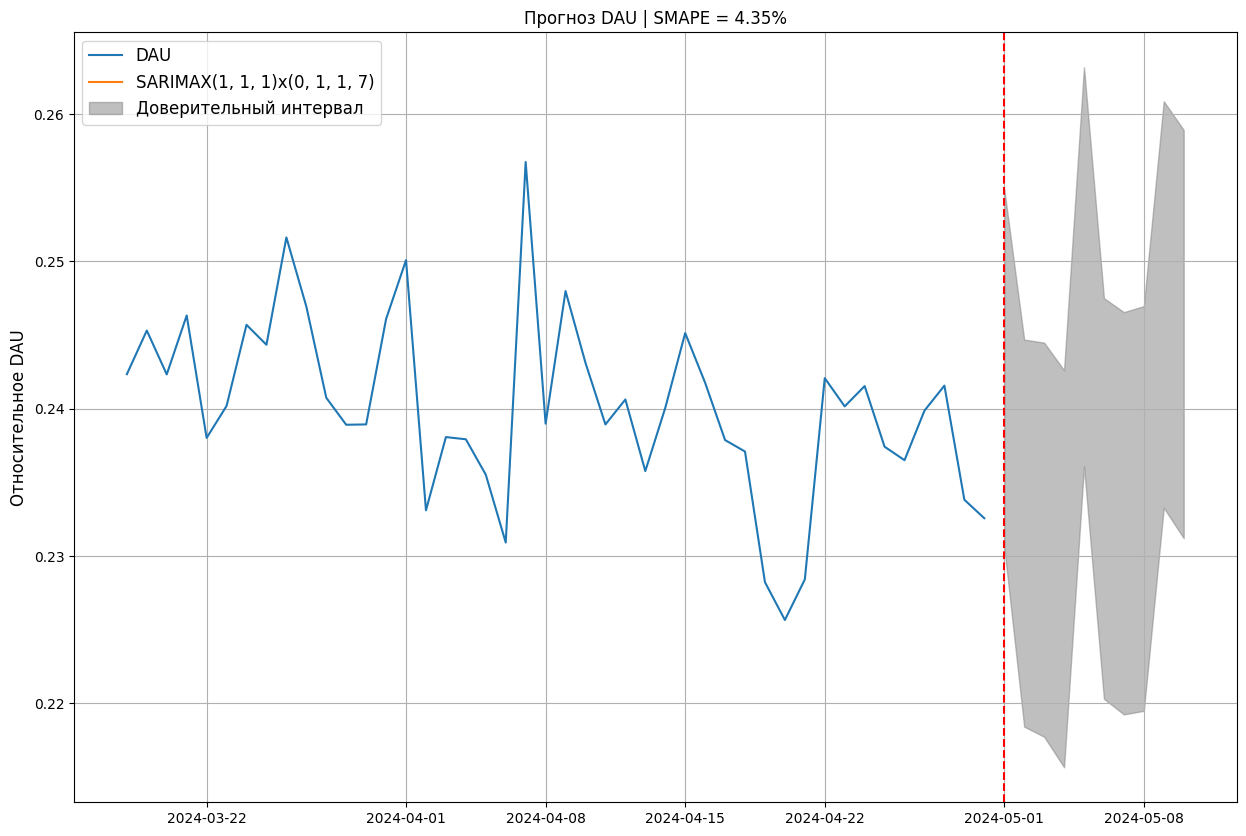

In [109]:
plt.figure(figsize=(15, 10))
plt.plot(df.loc[date_start:date_end, kpi], label='DAU')
plt.plot(y_pred.loc[date_start:date_end], label='SARIMAX(1, 1, 1)x(0, 1, 1, 7)')
plt.title(f'Прогноз DAU | SMAPE = {round(SMAPE(y_test.values,y_pred.values),2)}%')
plt.ylabel('Относительное DAU',fontsize=12)
plt.axvline(x=y_pred.index[0], color='red', linestyle='--')
plt.fill_between(confidence_intervals.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='gray', alpha=0.5, label='Доверительный интервал')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [110]:
res['Sarimax'] = round(WAPE(y_test.values,y_pred.values),2), round(SMAPE(y_test.values,y_pred.values),2),round(RMSE(y_test.values,y_pred.values),2)

### **VARX**

In [111]:
tdd = pd.read_excel('../actual_data.xlsx',sheet_name='tdd')
tdd.index = pd.to_datetime(tdd.dt)
tdd = tdd.loc['2022-09-19':]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



In [112]:
tdd['tdd_ok_35_plus_relative'] = tdd.tdd_ok_35_plus/tdd.tdd_runet_35_plus
df_var = pd.concat([df,tdd['tdd_ok_35_plus_relative']],axis=1)

In [113]:
var_features = ['dau_ok_35_plus_relative','tdd_ok_35_plus_relative','dummy_holidays','media_total_ots','seasonality_yearly_dau','seasonality_weekly_dau','trend_prophet_dau','dau_dzen_35_plus']

X = df_var[var_features].copy()

X_train = X.head(-horizon)
X_test = X.tail(horizon)

X_train = X_train.reindex(y_train.index)
X_test = X_test.reindex(y_test.index)

In [114]:
endog_train = X_train[['dau_ok_35_plus_relative','tdd_ok_35_plus_relative']]
exog_train = X_train[['media_total_ots','seasonality_yearly_dau','seasonality_weekly_dau','dummy_holidays']]

endog_test = X_test[['dau_ok_35_plus_relative','tdd_ok_35_plus_relative']]
exog_test = X_test[['media_total_ots','seasonality_yearly_dau','seasonality_weekly_dau','dummy_holidays']]

**Обучим модель VAR и выведем Summary**

In [115]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [116]:
model = VAR(endog=endog_train, exog=exog_train).fit()
print(model.summary())
predict = model.forecast(model.endog,steps=len(exog_test),exog_future=exog_test)
y_pred = predict[:,0] # выбираем dau_ok_35_plus_relative

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 10, Jun, 2024
Time:                     15:02:04
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -22.7875
Nobs:                     589.000    HQIC:                  -22.8510
Log likelihood:           5084.06    FPE:                1.14371e-10
AIC:                     -22.8916    Det(Omega_mle):     1.11701e-10
--------------------------------------------------------------------
Results for equation dau_ok_35_plus_relative
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              0.069921         0.006677           10.472           0.000
media_total_ots                    0.000509         0.000290            1.756       

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [117]:
res['VAR'] = round(SMAPE(y_pred,y_test.values),3), round(WAPE(y_pred,y_test.values),3), round(RMSE(y_pred,y_test.values),3)

**Выделим верхнюю и нижнюю границы ДИ**

In [118]:
lower = model.forecast_interval(y=model.endog,steps=len(exog_test),exog_future=exog_test)[1][:,0]
upper = model.forecast_interval(y=model.endog,steps=len(exog_test),exog_future=exog_test)[2][:,0]

In [119]:
y_pred=pd.Series(y_pred,index=y_test.index)

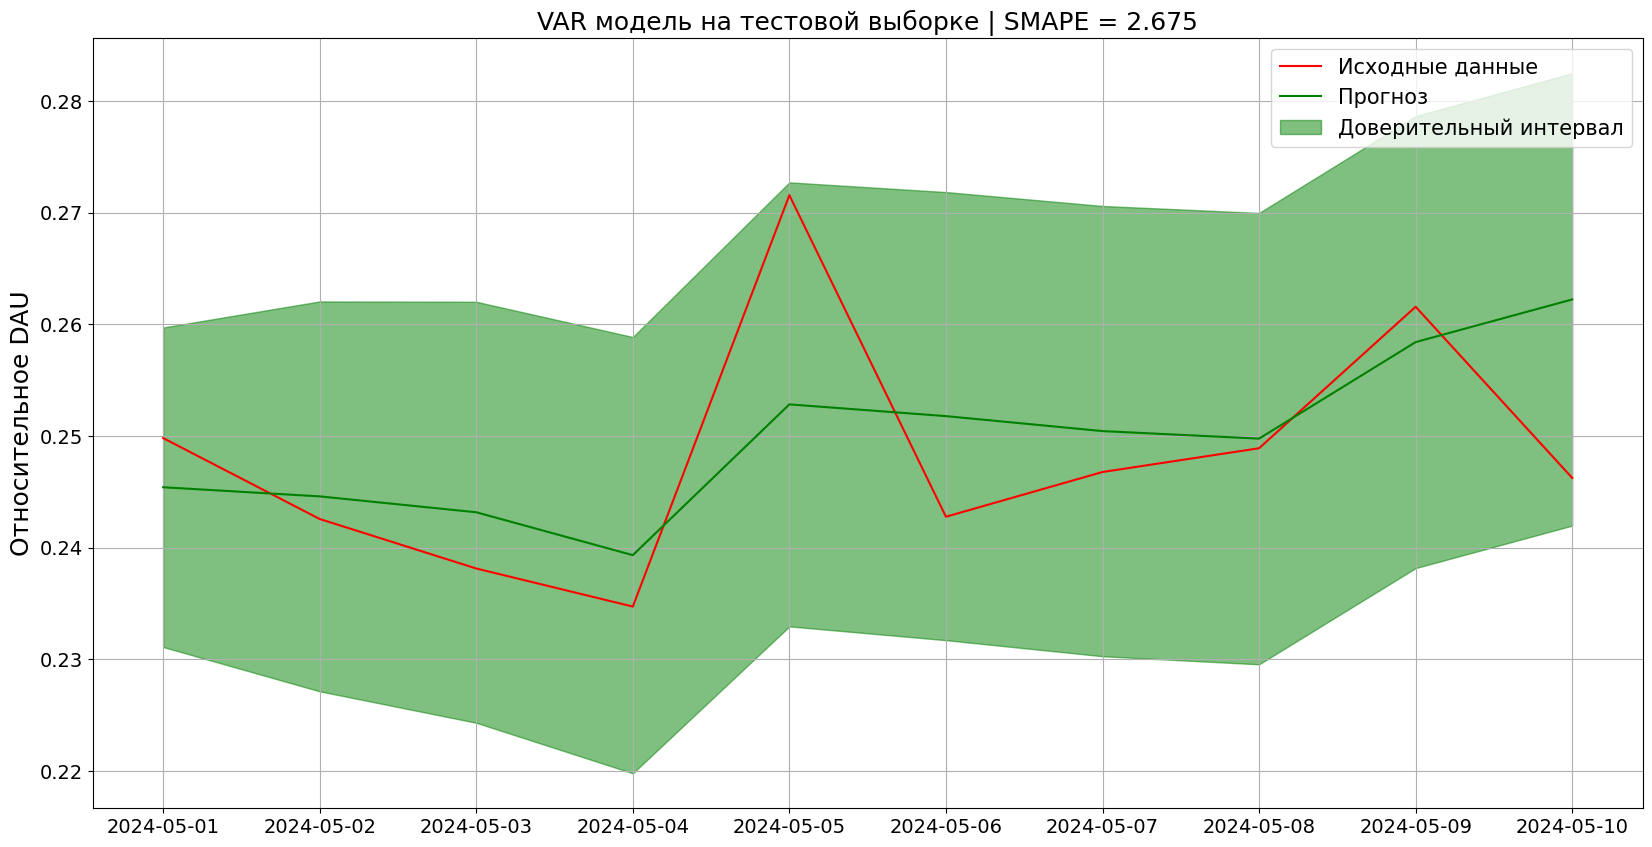

In [120]:
fig, ax = plt.subplots(figsize=(20, 10))

# График исходных данных
ax.plot(y_test.index, y_test, label='Исходные данные', color='red')

# График предсказанных значений
ax.plot(y_pred.index, y_pred, color='green', label='Прогноз')

# # График доверительного интервала
ax.fill_between(y_pred.index, lower, upper, color='green', alpha=0.5, label='Доверительный интервал')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

ax.set_ylabel('Относительное DAU', fontsize=18)
ax.set_title(f'VAR модель на тестовой выборке | SMAPE = {round(SMAPE(y_pred,y_test.values),3)}', fontsize=18)
ax.legend(fontsize=15)
ax.grid(True)

# ax.xaxis.set_major_locator(mdates.WeekdayLocator())
# plt.gcf().autofmt_xdate()

plt.show()


**Сводная таблица с метриками по всем моделям**

In [121]:
res

additive_2mnk_linear_reg_1  additive_2mnk_linear_reg_2  \
WAPE                        2.113                       2.209   
SMAPE                       2.083                       2.178   
RMSE                        0.006                       0.007   

       multi_linear_reg  Prophet  CatBoost  LinearGam  Ridge  Sarimax   VAR  
WAPE              2.186    1.983     2.852      2.761  2.162    4.490 2.675  
SMAPE             2.155    1.975     2.824      2.757  2.117    4.350 2.717  
RMSE              0.007    0.007     0.010      0.008  0.006    0.010 0.009

In [122]:
res.to_excel('model_results.xlsx')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/packaging/core.py:99: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/writer/excel.py:292: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



## **Causal Impact**

In [123]:
period_rk = len(df_var[(df_var.index >= date_start)&(df_var.index <= date_end)]) # период РК
df_causal = df_var[(df_var.index <= date_end)].reset_index() # ограничиваем выборку до РК

In [124]:
data = df_causal.rename(columns={'dt':'ds',kpi:'y','dummy_holidays':'holiday','trend':'trend_prophet_dau'}).copy()
data.reset_index(drop=True,inplace=True)

In [125]:
numeric_features = ['dau_dzen_35_plus','dau_youtube_35_plus','ba_spontaneous_kpi_percent_ttl_roll',
                    'media_total_ots','tdd_ok_35_plus_relative',]
data = data[numeric_features + ['ds','y']]
data['ds'] = pd.to_datetime(data.ds)

In [126]:
model = Prophet(seasonality_mode = 'additive',
                changepoint_prior_scale=0.5,
                yearly_seasonality=True,
                weekly_seasonality=True,
                seasonality_prior_scale=20)
# Добавление факторов
for i in numeric_features:
    model.add_regressor(i)
# Обучение модели
model.fit(data[:-period_rk])

15:02:04 - cmdstanpy - INFO - Chain [1] start processing
15:02:05 - cmdstanpy - INFO - Chain [1] done processing


In [127]:
future = model.make_future_dataframe(periods=period_rk, freq='D')
future = pd.concat([future,data.drop(columns=['ds','y'])],axis=1)

forecast = model.predict(future)

In [128]:
pred_wo_rk = forecast[(forecast.ds>=date_start)&(forecast.ds<=date_end)]['yhat']
y_true_rk = df[(df.index>=date_start)&(df.index<=date_end)][kpi]

In [129]:
pred_wo_rk.index = y_true_rk.index

In [130]:
impact_causal = round(np.mean((y_true_rk-pred_wo_rk)/y_true_rk*100),3)

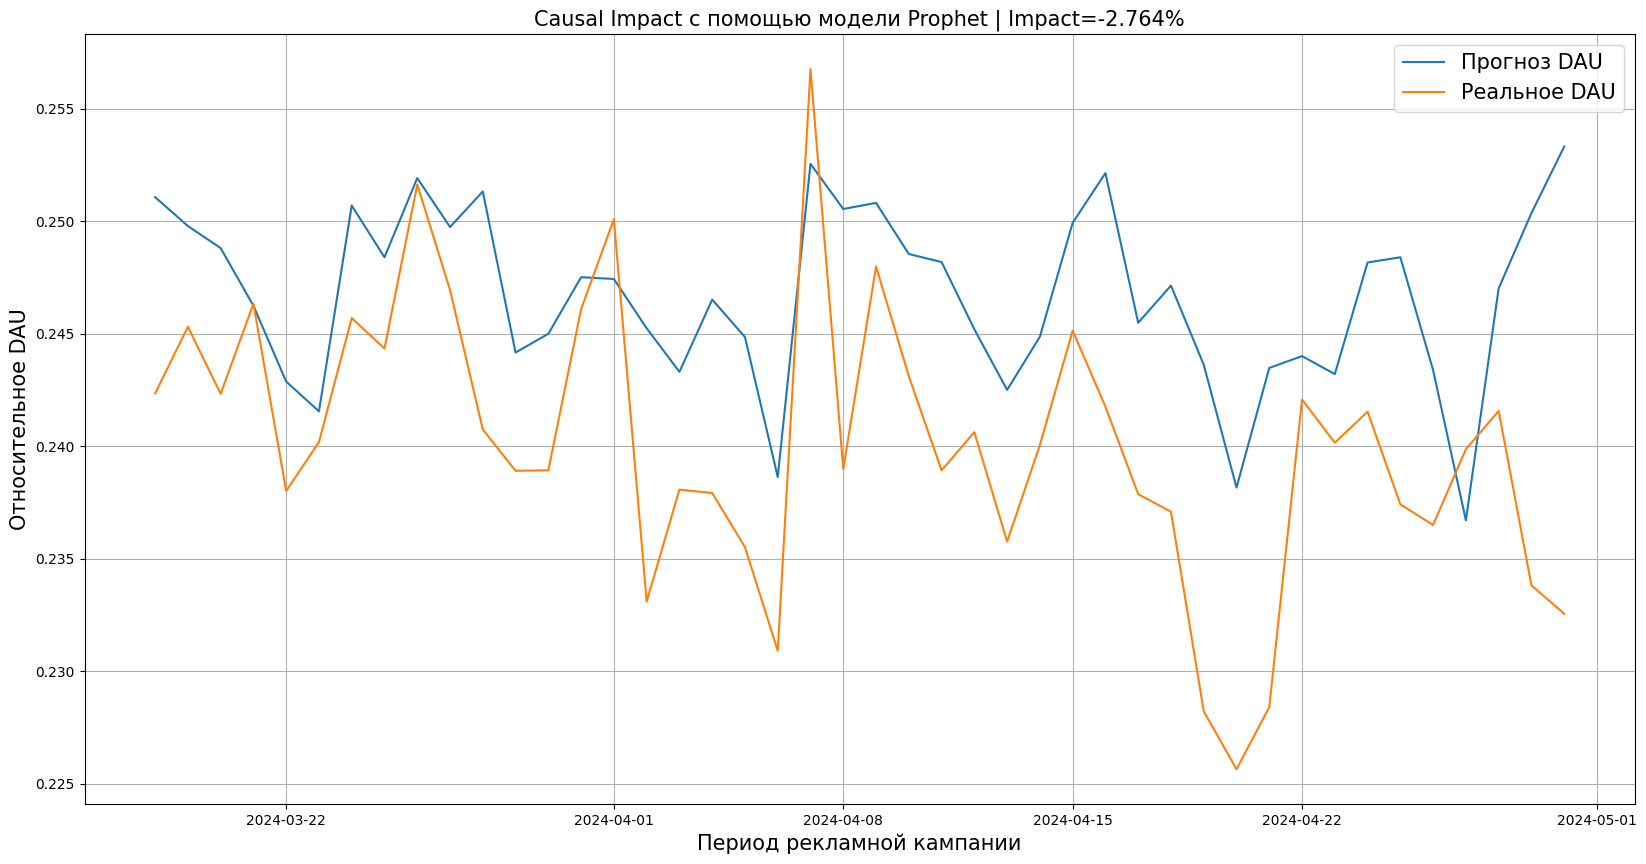

In [131]:
plt.figure(figsize=(20,10))
plt.plot(pred_wo_rk)
plt.plot(y_true_rk)
plt.legend(['Прогноз DAU','Реальное DAU'],fontsize=15)
plt.grid(True)
plt.title(f'Causal Impact с помощью модели Prophet | Impact={impact_causal}%',fontsize=15)
plt.xlabel('Период рекламной кампании',fontsize=15)
plt.ylabel('Относительное DAU',fontsize=15)
plt.show()